In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize
import scipy as sp
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from gensim.models import word2vec
from nltk import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

In [82]:
labels_nn=['artanddesign', 'australia-news', 'books', 'business', 'culture', 'education', 'environment',
        'film', 'food', 'football', 'lifeandstyle', 'media', 'money', 'music', 'politics', 'science',
        'society', 'sport', 'stage', 'technology', 'tv-and-radio', 'uk-news', 'us-news', 'world']

**First I define the functions needed to filter rare categories out of a dataset, visualize common words, remove stopwords, stem and tokenize**

# Functions

In [2]:
def filter_categories(df):
    '''Filter out infrequent categories and pieces with low word count'''
    all_cats= df['sectionId'].value_counts()
    all_cats = pd.DataFrame(all_cats)
    all_cats.reset_index(inplace=True)
    filt_cats=all_cats[:26]
    filt_cats_list = filt_cats['index'].tolist()
    filt_cats_list.remove('commentisfree')
    filt_cats_list.remove('global-development')
    filt_df = df[df['sectionId'].isin(filt_cats_list)]
    filt_df.reset_index(drop=True, inplace=True)
    filt_df = filt_df[filt_df['wordcount']>10]
    return filt_df

In [3]:
def visualize_top_10(freq_dist, title):
    '''plot top 10 words in dataset text'''

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

In [4]:
def plot_distribution_of_column_by_category(X, y, title, filt_cats_list):
    '''plot top 10 words by label in dataset'''
    if "label" not in X.columns:
        X["label"] = [y.loc[val, 'sectionId'] for val in X.index]
    fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15,20), frameon=False, dpi=100)
    for i, c in enumerate(filt_cats_list):
        row = (i-1)//4
        col = i%4-1
        ax = axes[row][col]
        all_words = X[X["label"] == c]['text_tokenized'].explode()
        freq_dist = FreqDist(all_words)
        top_10 = list(zip(*freq_dist.most_common(10)))
        tokens = top_10[0]
        counts = top_10[1]
        ax.bar(tokens, counts)

        ax.set_title(f"{title} {c}")
        ax.set_ylabel("Count")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis="x", rotation=90)
    plt.tight_layout()
    plt.show()
    fig.suptitle("Word Frequencies for All Tokens", fontsize=24);


In [83]:
def make_confusion_matrix(model, X, y):
    base_predictions = model.predict(X)
    cm = confusion_matrix(y, base_predictions, labels=labels_nn)
    cmp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=model.classes_)
    x_list = sorted(y.tolist())
    fig, ax = plt.subplots(figsize=(20,20))
    ax.xaxis.set_ticklabels(x_list, rotation=45);
    cmp.plot(ax=ax, xticks_rotation='vertical')



In [26]:
def make_class_report(model, X, y):
    base_predictions = model.predict(X)
    return classification_report(y, base_predictions, digits=3)

In [6]:
def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

In [7]:
def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

# Load full dataset

**Here I take the json file returned from the API calls and turn into a dataframe. I then make another with only the essential features, then another with only the 24 most important categories and save in the local machine, this is the main base df.**<br>
**I then make another df with 10k samples, save to local machine. This is the df I will use in this notebook.**<br>

In [ ]:
full_set=pd.read_json('data/art_res.json')

## Make full filtered

In [10]:
text_cat_df = full_set[['bodyText', 'sectionId', 'wordcount']]

## filter out rare categories & save

In [11]:
# call the category filter function
filtered_df = filter_categories(text_cat_df)

In [15]:
filtered_sample_df.to_json(r'data/filtered_sample_df.json')

In [12]:
filtered_df.to_json(r'data/filtered_df.json')

# Load df

In [2]:
filtered_df=pd.read_json('data/filtered_df.json')

In [9]:
filtered_df.head

<bound method NDFrame.head of                                                  bodyText sectionId  wordcount
0       In the worst moments, a press release dropped ...  football       1896
1       On the face of it, two perfectly respectable h...     sport        871
2       An American reporter who had been held by Vene...     world        535
3       After a storming season in the World Endurance...     sport        697
4       15 Mike Brown 7/10 Solid stuff after last week...     sport        502
...                                                   ...       ...        ...
605948  Boris Johnson has said that Russian oligarchs ...  politics        615
605949  Representatives from the six major religions a...   uk-news        664
605950  Birmingham will benefit from “the great gift o...   uk-news        564
605951  Two years ago the idea would have been prepost...     stage        364
605952  Thousands of girls as young as 11 are hiding s...   society        424

[604660 rows x 3 colu

In [10]:
filtered_df.isnull().values.any()

False

In [11]:
filtered_df['sectionId'].value_counts()

world             69783
football          52866
sport             50071
music             33365
business          33023
politics          31231
us-news           30459
australia-news    30012
uk-news           28541
lifeandstyle      27125
film              26511
books             25542
environment       21963
society           20819
tv-and-radio      20051
media             17196
stage             14174
technology        13999
money             11058
artanddesign      10638
education         10360
science            8794
food               8658
culture            8421
Name: sectionId, dtype: int64

In [8]:
filtered_sample_df=pd.read_json('data/filtered_sample_df.json')

# Model with 10k set

In [13]:
filtered_sample_df = filtered_df.sample(n=10000, random_state=5);

## Make test and train sets

In [9]:
X=pd.DataFrame(filtered_sample_df['bodyText'])
y=pd.DataFrame(filtered_sample_df['sectionId'])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
for df in [X_train, X_test, y_train, y_test]:
    df.reset_index(drop=True, inplace=True)

## Data Cleaning

**Here I create a new column with all the text in lower case. I then create another with tokenized text, which will be of use when doing the word embedding models and creating visualizations of most common words.**<br>
**I then create a tf/idf vector of the lower case text and fit a base Naive-Bayes model on it**

### case/tokenize

In [12]:
X_train['bodyTextlow'] = X_train['bodyText'].str.lower()

<ipython-input-12-43f6b66d66a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['bodyTextlow'] = X_train['bodyText'].str.lower()


In [13]:
basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)

In [14]:
X_train["text_tokenized"] = X_train['bodyTextlow'].apply(tokenizer.tokenize)

<ipython-input-14-2e60dd496243>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["text_tokenized"] = X_train['bodyTextlow'].apply(tokenizer.tokenize)


In [15]:
X_test['bodyTextlow'] = X_test['bodyText'].str.lower()
X_test["text_tokenized"] = X_test['bodyTextlow'].apply(tokenizer.tokenize)

<ipython-input-15-12dc1533d99c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['bodyTextlow'] = X_test['bodyText'].str.lower()
<ipython-input-15-12dc1533d99c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["text_tokenized"] = X_test['bodyTextlow'].apply(tokenizer.tokenize)


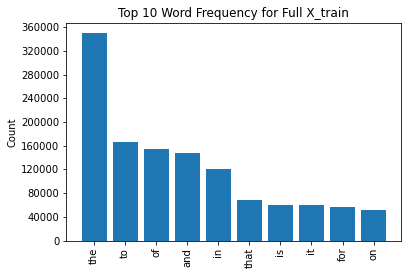

In [18]:
# Create a frequency distribution for X_train
train_freq_dist = FreqDist(X_train["text_tokenized"].explode())

# Plot the top 10 tokens
visualize_top_10(train_freq_dist, "Top 10 Word Frequency for Full X_train")

In [60]:
# add label to X_train
X_train["label"] = [y_train.loc[val, 'sectionId'] for val in X_train.index]

<ipython-input-60-43338ff35eb9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["label"] = [y_train.loc[val, 'sectionId'] for val in X_train.index]


In [61]:
filt_cats_list = filtered_sample_df['sectionId'].unique().tolist()

**We can see from these visualizations that there is not obvious difference in frequency of common words across the categories, so can safely remove the stopwords without losing too much info.**<br>

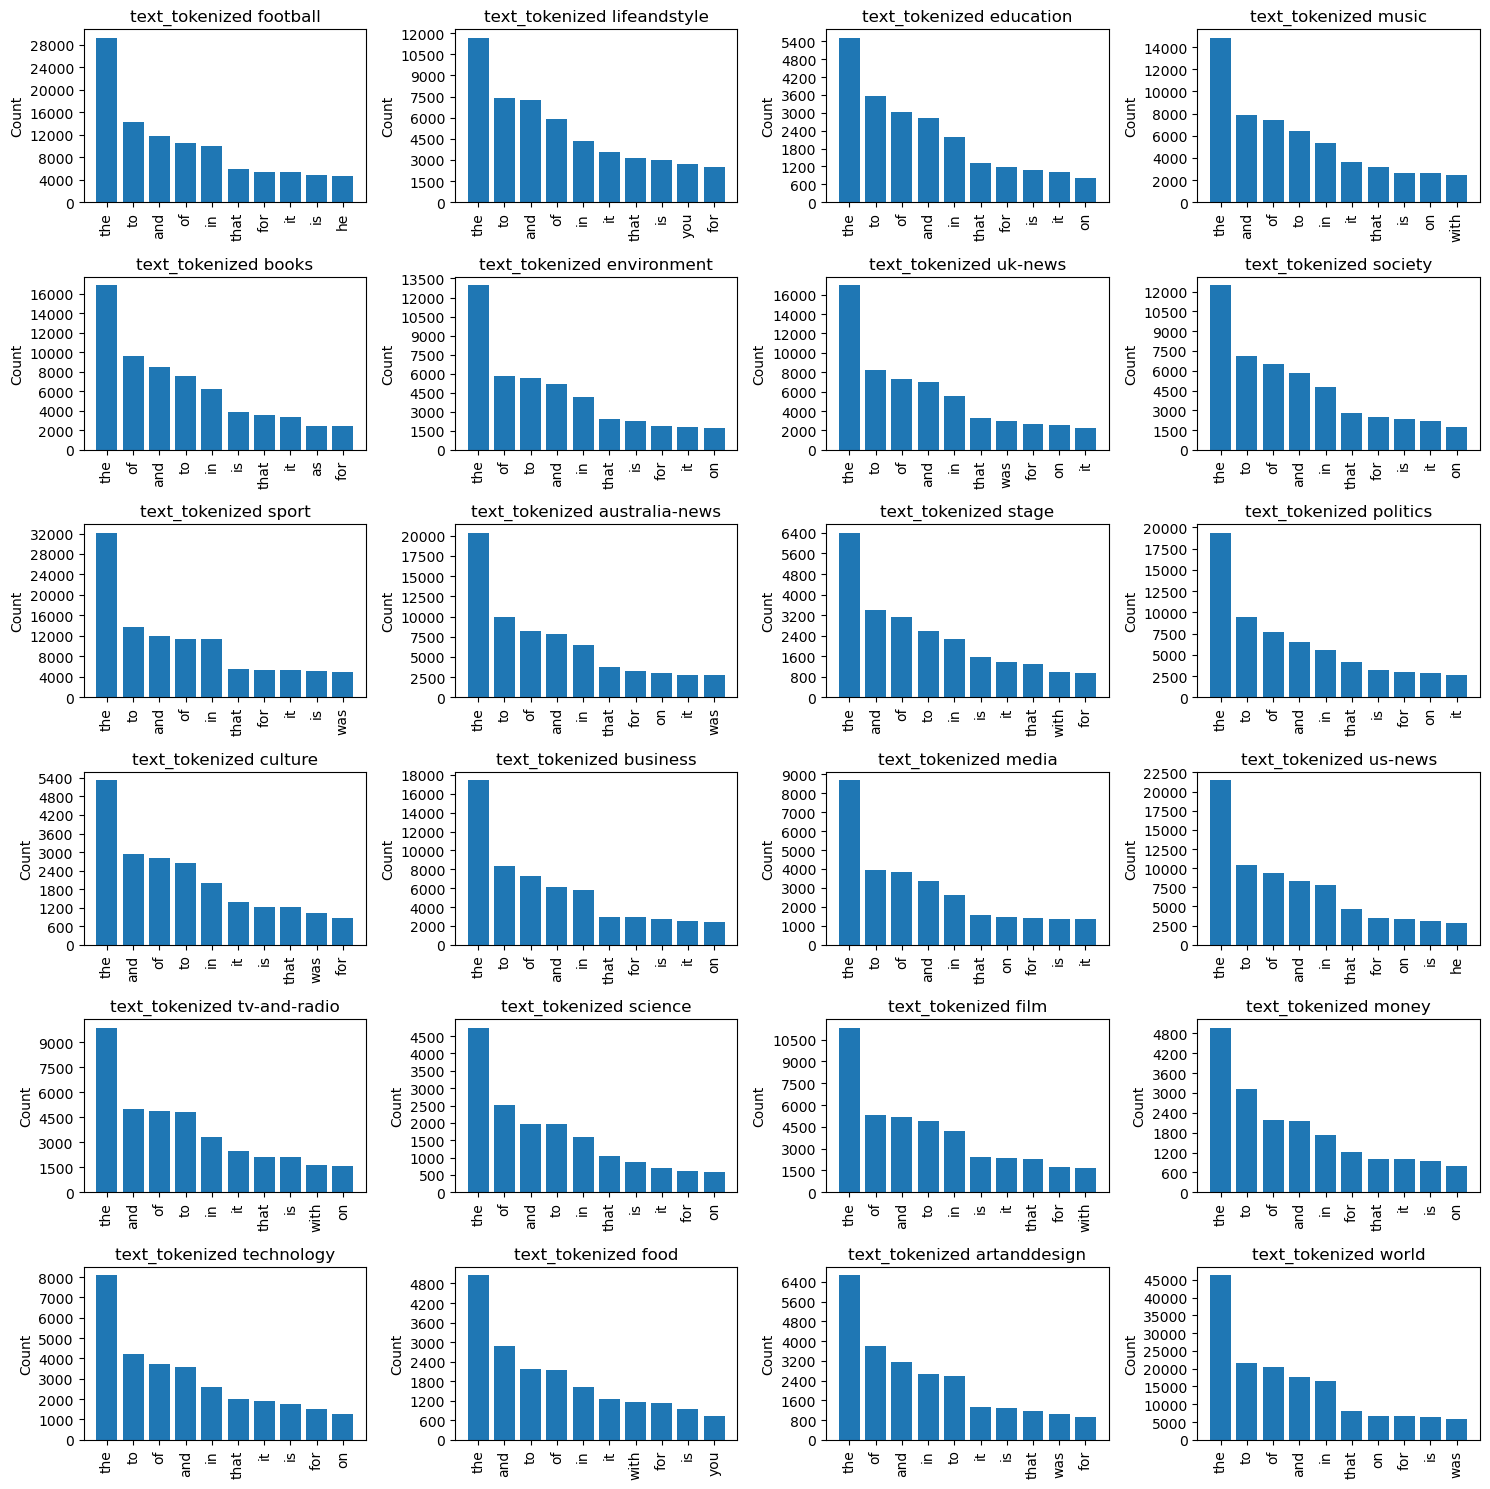

In [23]:
plot_distribution_of_column_by_category(X_train, y_train, "text_tokenized", filt_cats_list)

### Make base tf-idf vector

In [16]:
tfidf_base = TfidfVectorizer(max_features=1000)
X_train_vector_base = tfidf_base.fit_transform(X_train["bodyText"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vector_base, columns=tfidf_base.get_feature_names())

,000,10,100,11,12,13,14,15,16,17,...,wrong,wrote,year,years,yes,yet,york,you,young,your
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.00000,0.000000,0.023682,0.000000,0.000000,0.00000,0.109597,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.096887,0.06574,0.000000,0.000000,0.000000
2,0.069353,0.033895,0.047251,0.000000,0.000000,0.0,0.0,0.0,0.048102,0.0,...,0.000000,0.00000,0.069246,0.025746,0.000000,0.035808,0.00000,0.000000,0.039552,0.000000
3,0.018633,0.018213,0.025390,0.000000,0.023040,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.02530,0.049612,0.000000,0.000000,0.000000,0.00000,0.128044,0.000000,0.000000
4,0.031005,0.030306,0.084496,0.041415,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.00000,0.041276,0.000000,0.000000,0.064033,0.00000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.000000,0.021071,0.000000,0.014397,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.00000,0.114789,0.032009,0.016505,0.000000,0.00000,0.066659,0.012293,0.010597
7996,0.000000,0.000000,0.000000,0.000000,0.035717,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.00000,0.019227,0.021446,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7997,0.000000,0.000000,0.000000,0.000000,0.031371,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.026199,0.00000,0.017434,0.000000,0.000000
7998,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.029851,0.00000,0.028691,0.016001,0.000000,0.000000,0.00000,0.074049,0.049162,0.000000


### Make prior probabilites for NB model

**I was a little concerned the classes may be unbalanced, so worked out the prior probabilities of each category with the idea of passing these into the same base NB model to see if it performed better**

In [30]:
le = LabelEncoder()
label = le.fit_transform(y_train)
y_train['num'] = label
y_train



C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-30-3a26735299ac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['num'] = label


,sectionId,num
0,culture,4
1,us-news,22
2,politics,14
3,world,23
4,society,16
...,...,...
7995,sport,17
7996,world,23
7997,football,9
7998,education,5


In [31]:
values = y_train['num'].value_counts(dropna=False, normalize=True).keys().tolist()
counts = y_train['num'].value_counts(dropna=False, normalize=True).tolist()
value_dict = dict(zip(values, counts))


In [33]:
value_dict

{23: 0.11375,
 17: 0.0865,
 9: 0.083125,
 13: 0.058625,
 3: 0.055375,
 22: 0.052375,
 21: 0.051875,
 1: 0.050125,
 14: 0.0485,
 10: 0.047875,
 2: 0.043875,
 7: 0.037875,
 16: 0.03625,
 6: 0.03275,
 20: 0.03075,
 11: 0.029125,
 18: 0.022625,
 19: 0.02225,
 5: 0.0185,
 12: 0.018,
 0: 0.017,
 4: 0.016375,
 8: 0.014,
 15: 0.0125}

In [34]:
priors = []
for i in range(24):
    priors.append(value_dict[i])
priors

[0.017,
 0.050125,
 0.043875,
 0.055375,
 0.016375,
 0.0185,
 0.03275,
 0.037875,
 0.014,
 0.083125,
 0.047875,
 0.029125,
 0.018,
 0.058625,
 0.0485,
 0.0125,
 0.03625,
 0.0865,
 0.022625,
 0.02225,
 0.03075,
 0.051875,
 0.052375,
 0.11375]

## Make baselines

**Here I make and fit the baseline models. Throughout I will use cross val to give me an idea of the performance, and then score the test set separately**

In [35]:
# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vector_base, y_train['sectionId'])
baseline_cv

array([0.52    , 0.50875 , 0.509375, 0.518125, 0.51375 ])

### test set

In [18]:
X_test_vector_base = tfidf_base.transform(X_test["bodyText"])

In [19]:
baseline_model.fit(X_train_vector_base, y_train['sectionId'])
baseline_model.score(X_train_vector_base, y_train['sectionId'])

0.564375

In [20]:
baseline_model.score(X_test_vector_base, y_test['sectionId'])

0.539

In [28]:
base_report = make_class_report(baseline_model, X_test_vector_base, y_test['sectionId'])
print(base_report)

                precision    recall  f1-score   support

  artanddesign      0.000     0.000     0.000        30
australia-news      0.857     0.333     0.480       108
         books      0.667     0.681     0.674        91
      business      0.583     0.720     0.644       107
       culture      0.000     0.000     0.000        23
     education      0.800     0.229     0.356        35
   environment      0.731     0.235     0.355        81
          film      0.864     0.487     0.623        78
          food      0.500     0.038     0.071        26
      football      0.912     0.924     0.918       158
  lifeandstyle      0.382     0.765     0.510        85
         media      0.900     0.261     0.404        69
         money      1.000     0.036     0.069        28
         music      0.451     0.898     0.601       108
      politics      0.793     0.625     0.699       104
       science      0.000     0.000     0.000        38
       society      0.636     0.288     0.396  

<ipython-input-5-d78ae98f6f6e>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(x_list, rotation=45);


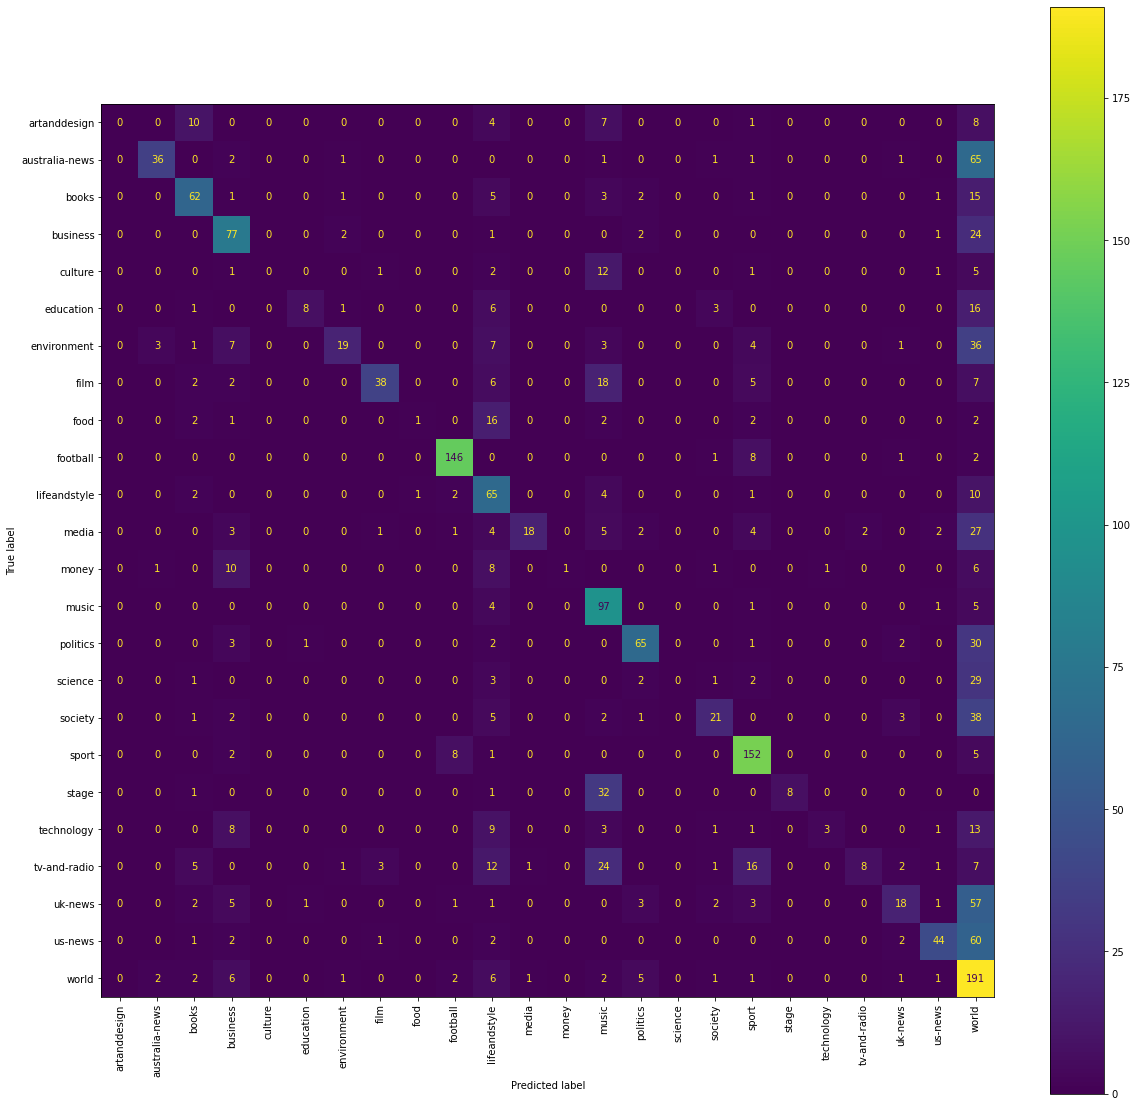

In [21]:
make_confusion_matrix(baseline_model, X_test_vector_base, y_test['sectionId'])

**While obviously showing room for improvement, with 24 categories 54% accuracy is much better than chance, and shows that the dataset is likely to be suitable for the task. We can see straight away that world news is the problem area, which is not surprising as it is the most common category, but also overlaps with other categories such as uk-news, us-news etc.**<br>
**It isn't immediately obvious how we can help it discern between these because it seems the boundaries are drawn by importance of story rather than language necessarily, although bigger models working on more data may find a way.**

### Make balanced baseline

**We can see here that feeding in prior probabilities doesn't improve performance, so keep as is.**

In [36]:
balance_model = MultinomialNB(class_prior=priors)

# Evaluate the classifier on X_train_vectorized and y_train
balance_cv = cross_val_score(balance_model, X_train_vector_base, y_train['num'])
balance_cv

array([0.52   , 0.50875, 0.50875, 0.51875, 0.51375])

### Test set

In [37]:
balance_model.fit(X_train_vector_base, y_train['sectionId'])
balance_model.score(X_train_vector_base, y_train['sectionId'])

0.564375

In [38]:
balance_model.score(X_test_vector_base, y_test['sectionId'])

0.539

In [39]:
base_report = make_class_report(balance_model, X_test_vector_base, y_test['sectionId'])
print(base_report)

                precision    recall  f1-score   support

  artanddesign      0.000     0.000     0.000        30
australia-news      0.857     0.333     0.480       108
         books      0.667     0.681     0.674        91
      business      0.583     0.720     0.644       107
       culture      0.000     0.000     0.000        23
     education      0.800     0.229     0.356        35
   environment      0.731     0.235     0.355        81
          film      0.864     0.487     0.623        78
          food      0.500     0.038     0.071        26
      football      0.912     0.924     0.918       158
  lifeandstyle      0.382     0.765     0.510        85
         media      0.900     0.261     0.404        69
         money      1.000     0.036     0.069        28
         music      0.451     0.898     0.601       108
      politics      0.793     0.625     0.699       104
       science      0.000     0.000     0.000        38
       society      0.636     0.288     0.396  

C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<ipython-input-54-22f4a674cabe>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(x_list, rotation=45);


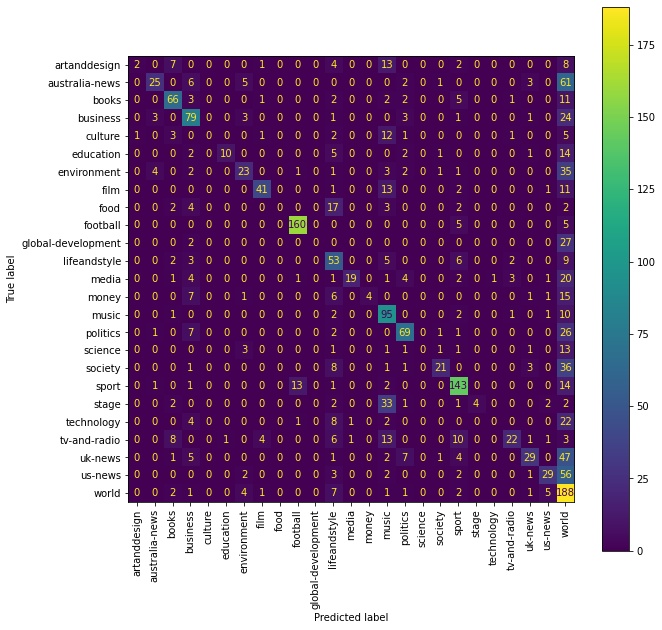

In [55]:
make_confusion_matrix(balance_model, X_test_vector_base, y_test['sectionId'])

## Preprocessing

**As seen, we can safely remove the stopwords. This gives us much more distinctive common words, so will likely help the model. We can see the word said is very common in some categories. I could add this to the stopwords list, but it is obviously more common in some categories than others, presumably some categories contain more quotes than others, so it is important we keep it. I add a column of text wothout stopwords, again mainly for use in visualizations and for the later word embedding**<br>
**I then vectorize, but tell it to leave out the stop words, and pass into the model**

### Remove stopwords

In [40]:
stopwords_list = stopwords.words('english')

In [88]:
X_train_nostop=X_train.copy()

In [89]:
X_train_nostop["text_tokenized"] = X_train_nostop["text_tokenized"].apply(lambda x: remove_stopwords(x))

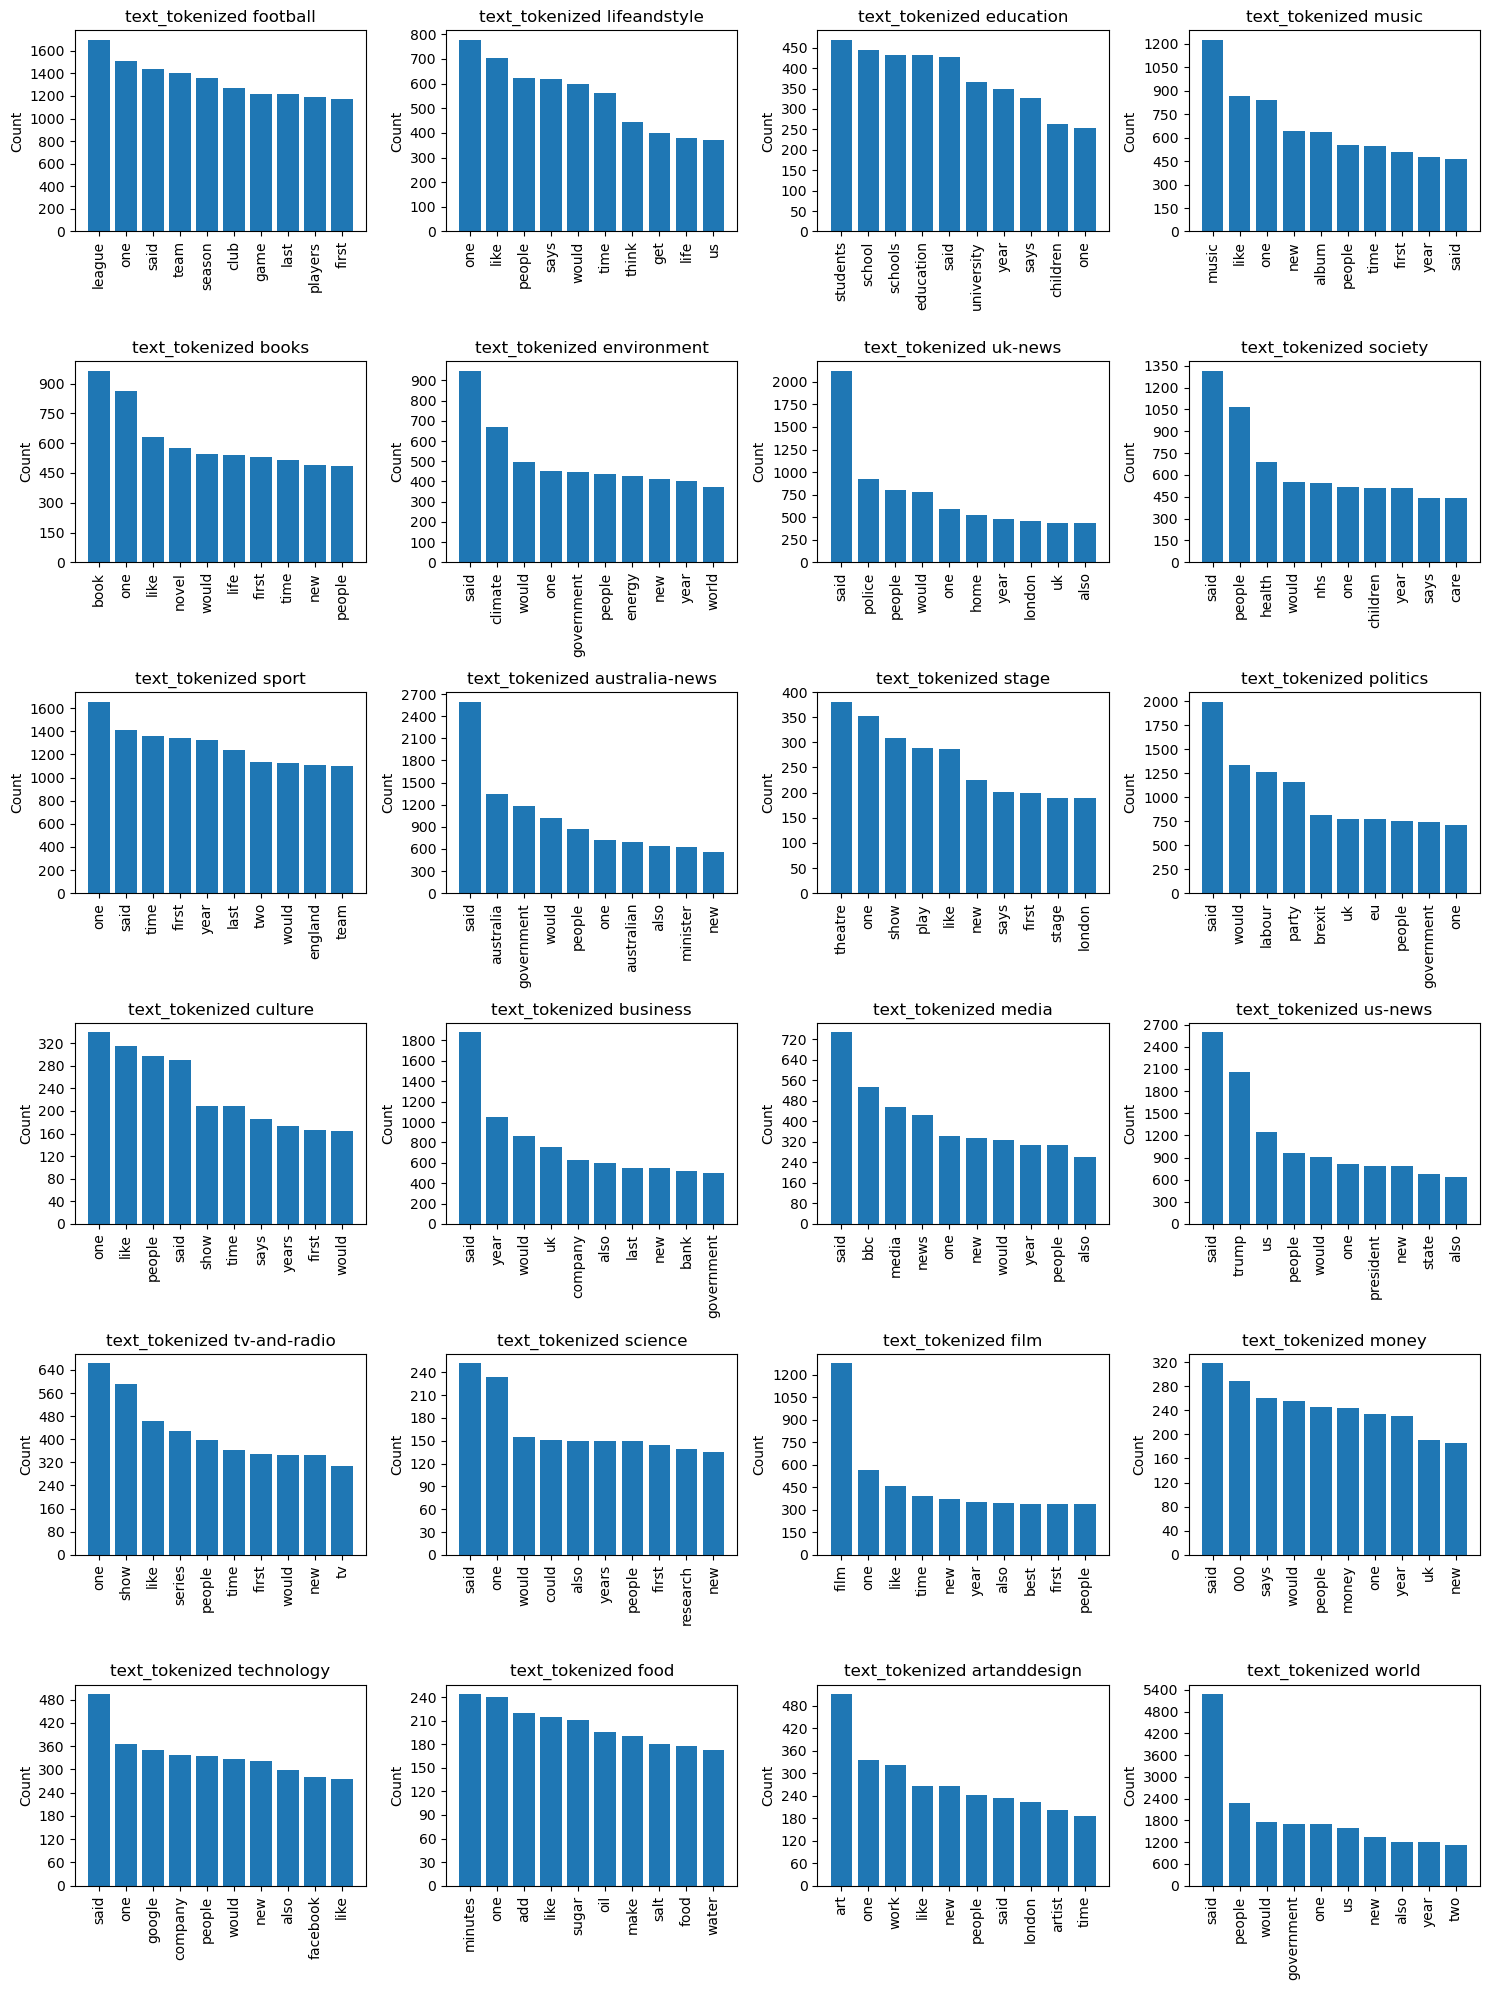

In [36]:
plot_distribution_of_column_by_category(X_train_nostop, y_train, "text_tokenized", filt_cats_list)

### Stopwords model

In [43]:
tfidf_stop = TfidfVectorizer(
    max_features=1000,
    stop_words=stopwords_list
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vector_stop = tfidf_stop.fit_transform(X_train["bodyText"])


In [44]:
stopwords_removed_cv = cross_val_score(baseline_model, X_train_vector_stop, y_train['sectionId'])
stopwords_removed_cv

array([0.629375, 0.61625 , 0.62    , 0.623125, 0.62375 ])

#### test

In [45]:
stop_model = MultinomialNB()
stop_model.fit(X_train_vector_stop, y_train['sectionId'])
stop_model.score(X_train_vector_stop, y_train['sectionId'])

0.687625

In [46]:
X_test_vector_stop = tfidf_stop.transform(X_test["bodyText"])

In [47]:
stop_model.score(X_test_vector_stop, y_test['sectionId'])

0.647

In [49]:
print(make_class_report(stop_model, X_test_vector_stop, y_test['sectionId']))

                precision    recall  f1-score   support

  artanddesign      0.800     0.267     0.400        30
australia-news      0.800     0.630     0.705       108
         books      0.635     0.725     0.677        91
      business      0.577     0.738     0.648       107
       culture      0.000     0.000     0.000        23
     education      0.655     0.543     0.594        35
   environment      0.685     0.457     0.548        81
          film      0.803     0.731     0.765        78
          food      0.833     0.192     0.312        26
      football      0.931     0.937     0.934       158
  lifeandstyle      0.417     0.765     0.539        85
         media      0.818     0.391     0.529        69
         money      1.000     0.321     0.486        28
         music      0.595     0.870     0.707       108
      politics      0.743     0.721     0.732       104
       science      1.000     0.053     0.100        38
       society      0.574     0.479     0.522  

<ipython-input-35-d78ae98f6f6e>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(x_list, rotation=45);


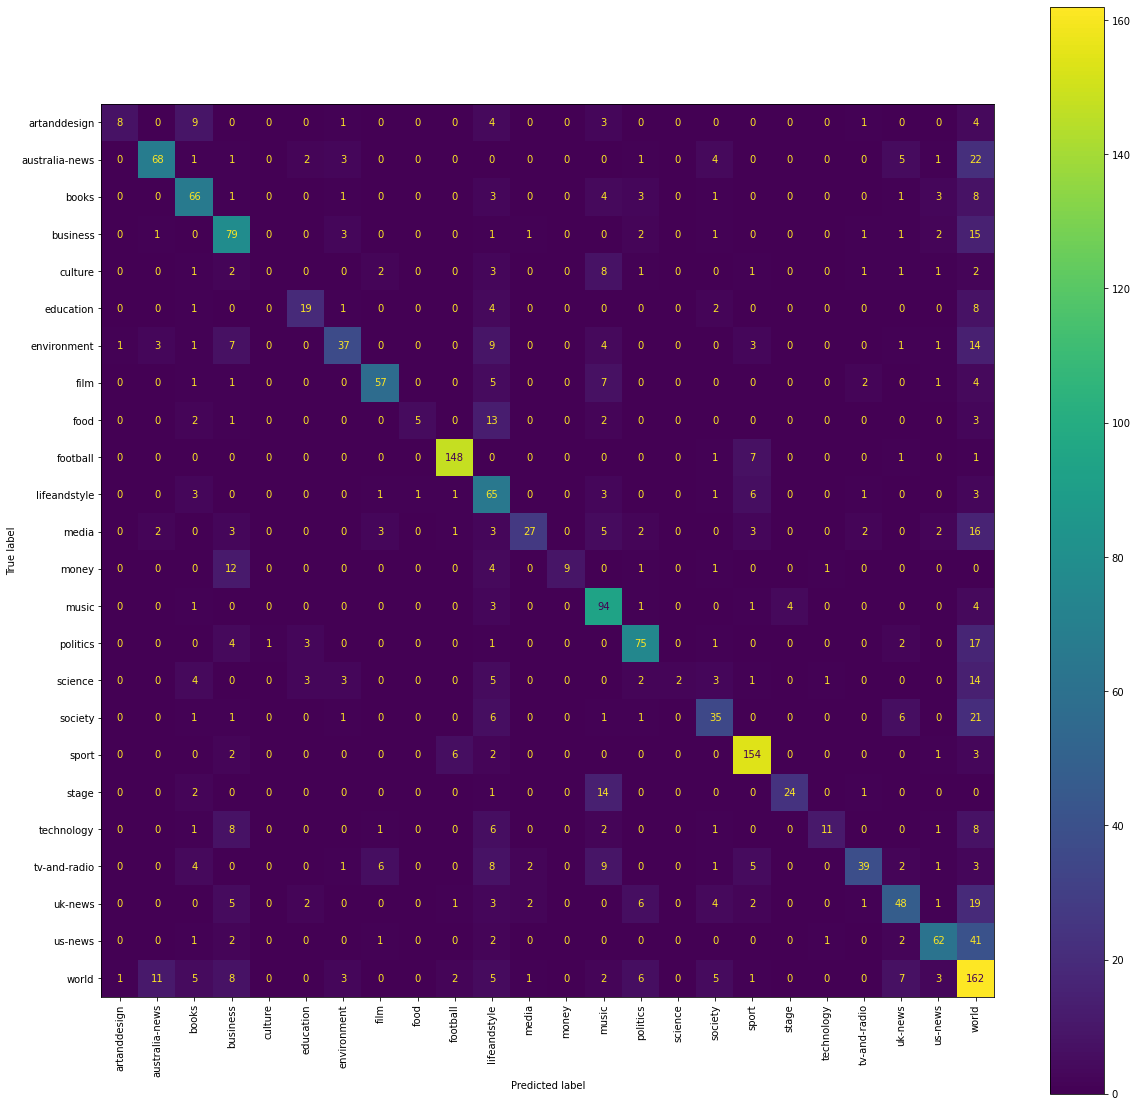

In [42]:
make_confusion_matrix(stop_model, X_test_vector_stop, y_test['sectionId'])

**We can already see a marked improvement to 65%. World news and business/money still sticking points**

### Stemming

**Next I stemmed the words and created a new tf/idf vector and model. Given more resources I would also have performed lemmatization, but as it was I would have to limit the ultimate size of the dataset I could work with due to the extra memory needed. This seemed an expensive trade off.**

In [50]:
stemmer = SnowballStemmer(language="english")

In [51]:
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

### Stem models

In [52]:
# Instantiate the vectorizer
tfidf_stem = TfidfVectorizer(
    max_features=1000,
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vector_stem = tfidf_stem.fit_transform(X_train["bodyText"])

In [53]:
stemmed_cv = cross_val_score(baseline_model, X_train_vector_stem, y_train['sectionId'])
stemmed_cv

array([0.6375  , 0.633125, 0.610625, 0.624375, 0.6275  ])

#### test

In [54]:
stem_model = MultinomialNB()
stem_model.fit(X_train_vector_stem, y_train['sectionId'])
stem_model.score(X_train_vector_stem, y_train['sectionId'])

0.68575

In [55]:
X_test_vector_stem = tfidf_stem.transform(X_test["bodyText"])

In [56]:
stem_model.score(X_test_vector_stem, y_test['sectionId'])

0.6565

In [57]:
print(make_class_report(stem_model, X_test_vector_stem, y_test['sectionId']))

                precision    recall  f1-score   support

  artanddesign      0.857     0.400     0.545        30
australia-news      0.780     0.593     0.674       108
         books      0.753     0.802     0.777        91
      business      0.538     0.785     0.639       107
       culture      0.667     0.087     0.154        23
     education      0.690     0.571     0.625        35
   environment      0.655     0.444     0.529        81
          film      0.744     0.859     0.798        78
          food      0.800     0.308     0.444        26
      football      0.914     0.937     0.925       158
  lifeandstyle      0.441     0.741     0.553        85
         media      0.784     0.420     0.547        69
         money      1.000     0.250     0.400        28
         music      0.642     0.880     0.742       108
      politics      0.735     0.721     0.728       104
       science      1.000     0.079     0.146        38
       society      0.597     0.548     0.571  

<ipython-input-35-d78ae98f6f6e>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(x_list, rotation=45);


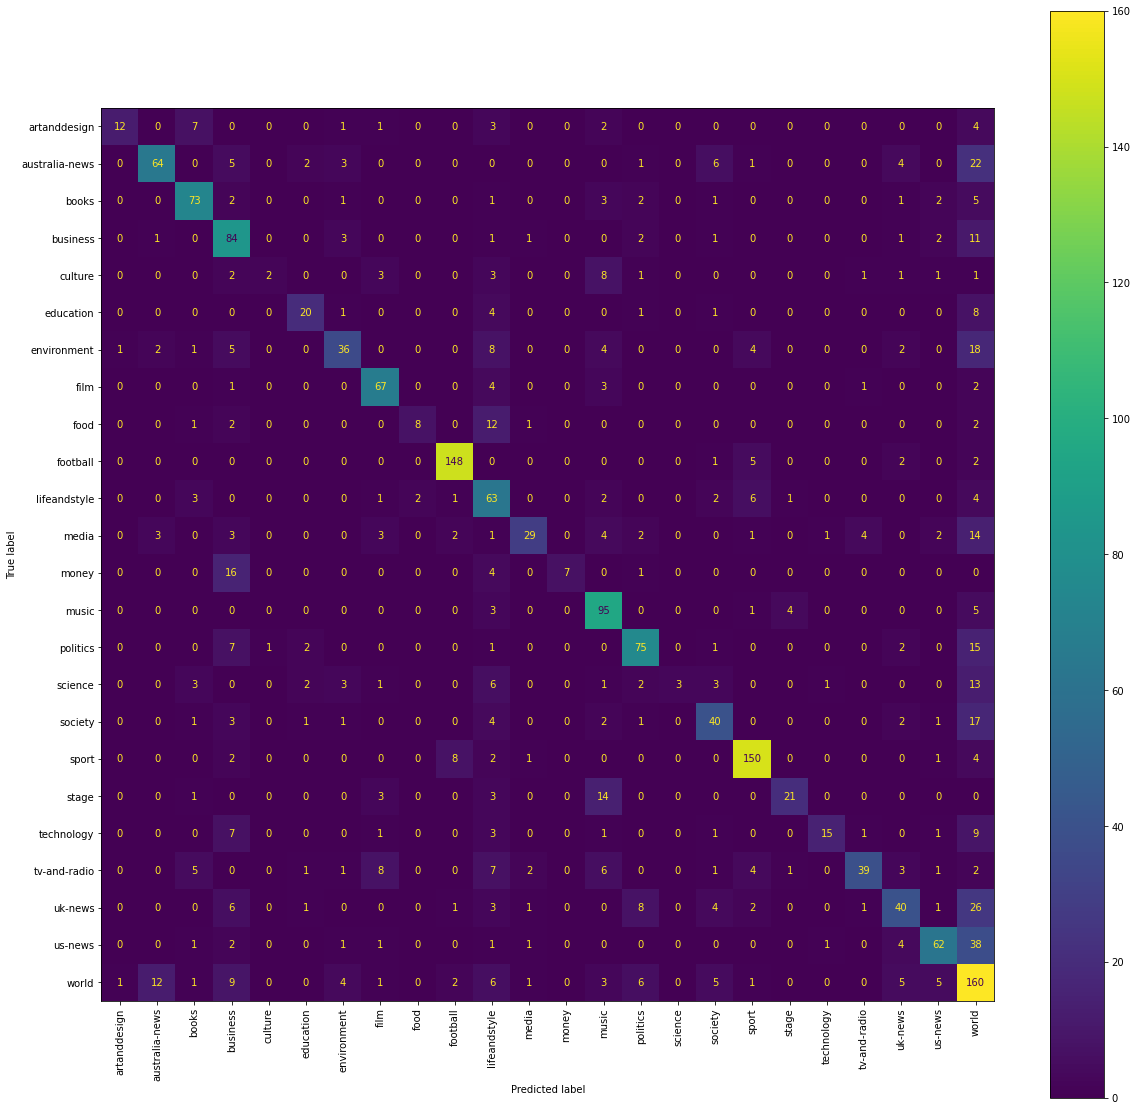

In [50]:
make_confusion_matrix(stem_model, X_test_vector_stem, y_test['sectionId'])

**We see slight improvement, so will keep in our final model**

## Feature engineering

**I'm looking for a way to solve the world news issues, so see if number of sentences varies between categories. Maybe important world news stories are longer. I added a column to the vector with the raw number of sentences then modeled. It performed badly, probably because the numbers are too large, so normalized this column and repeated.**<br>
**I did also use a PoS library to extract named entities, and OHE'd the most frequent ones, added to the tf/idf vector and passed into model, but it performed badly so didn't include the code. I have saved the functions if needed.**

### no of sentences

In [58]:
X_train["num_sentences"] = X_train["bodyText"].apply(lambda x: len(sent_tokenize(x)))

<ipython-input-58-b469fbb88ede>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["num_sentences"] = X_train["bodyText"].apply(lambda x: len(sent_tokenize(x)))


<AxesSubplot:xlabel='label'>

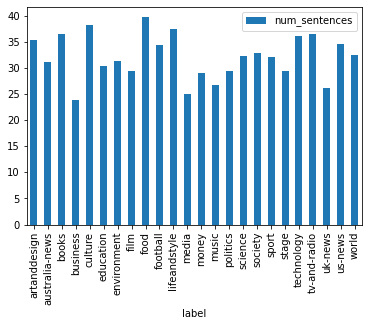

In [62]:
mean_sent_df = X_train.groupby("label").mean()
mean_sent_df.plot.bar()

In [63]:
extracted_col = np.array([X_train["num_sentences"]])
extracted_col = np.transpose(extracted_col)

In [64]:
X_train_vector_sentNo = sp.sparse.hstack((X_train_vector_stem, extracted_col))

#### Model

In [65]:
sentsize_cv = cross_val_score(baseline_model, X_train_vector_sentNo, y_train['sectionId'])
sentsize_cv

array([0.59125 , 0.59125 , 0.561875, 0.59125 , 0.57625 ])

In [66]:
# maybe warped by size v tfid. standardize

max_sent = X_train.nlargest(1,"num_sentences")['num_sentences'].values[0]
X_train["num_sentences_st"] = X_train['num_sentences'].apply(lambda x: x/max_sent)

<ipython-input-66-4b5cb45d125a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["num_sentences_st"] = X_train['num_sentences'].apply(lambda x: x/max_sent)


In [67]:
extracted_col1 = np.array([X_train["num_sentences_st"]])
extracted_col1 = np.transpose(extracted_col1)

In [68]:
X_train_vector_sentNo1 = sp.sparse.hstack((X_train_vector_stem, extracted_col1))

#### Model1

In [69]:
sentsize_cv1 = cross_val_score(baseline_model, X_train_vector_sentNo1, y_train['sectionId'])
sentsize_cv1

array([0.63875 , 0.633125, 0.61    , 0.624375, 0.6275  ])

In [70]:
print(stemmed_cv.mean(), sentsize_cv1.mean())

0.626625 0.62675


#### test

In [71]:
X_test["num_sentences"] = X_test["bodyText"].apply(lambda x: len(sent_tokenize(x)))

<ipython-input-71-4f9f13e2b479>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["num_sentences"] = X_test["bodyText"].apply(lambda x: len(sent_tokenize(x)))


In [72]:
max_sent_test = X_test.nlargest(1,"num_sentences")['num_sentences'].values[0]
X_test["num_sentences_st"] = X_test['num_sentences'].apply(lambda x: x/max_sent_test)

<ipython-input-72-fad7bb816cdd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["num_sentences_st"] = X_test['num_sentences'].apply(lambda x: x/max_sent_test)


In [73]:
extracted_col_test = np.array([X_test["num_sentences_st"]])
extracted_col_test = np.transpose(extracted_col_test)

In [74]:
X_test_vector_sentNo = sp.sparse.hstack((X_test_vector_stem, extracted_col_test))

In [75]:
sent_model = MultinomialNB()
sent_model.fit(X_train_vector_sentNo1, y_train['sectionId'])
sent_model.score(X_train_vector_sentNo1, y_train['sectionId'])

0.686375

In [76]:
sent_model.score(X_test_vector_sentNo, y_test['sectionId'])

0.6555

In [77]:
print(make_class_report(sent_model, X_test_vector_sentNo, y_test['sectionId']))

                precision    recall  f1-score   support

  artanddesign      0.857     0.400     0.545        30
australia-news      0.780     0.593     0.674       108
         books      0.753     0.802     0.777        91
      business      0.538     0.785     0.639       107
       culture      0.667     0.087     0.154        23
     education      0.690     0.571     0.625        35
   environment      0.655     0.444     0.529        81
          film      0.744     0.859     0.798        78
          food      0.800     0.308     0.444        26
      football      0.914     0.937     0.925       158
  lifeandstyle      0.441     0.741     0.553        85
         media      0.763     0.420     0.542        69
         money      1.000     0.250     0.400        28
         music      0.642     0.880     0.742       108
      politics      0.735     0.721     0.728       104
       science      1.000     0.079     0.146        38
       society      0.597     0.548     0.571  

<ipython-input-83-630b76b753b8>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(x_list, rotation=45);


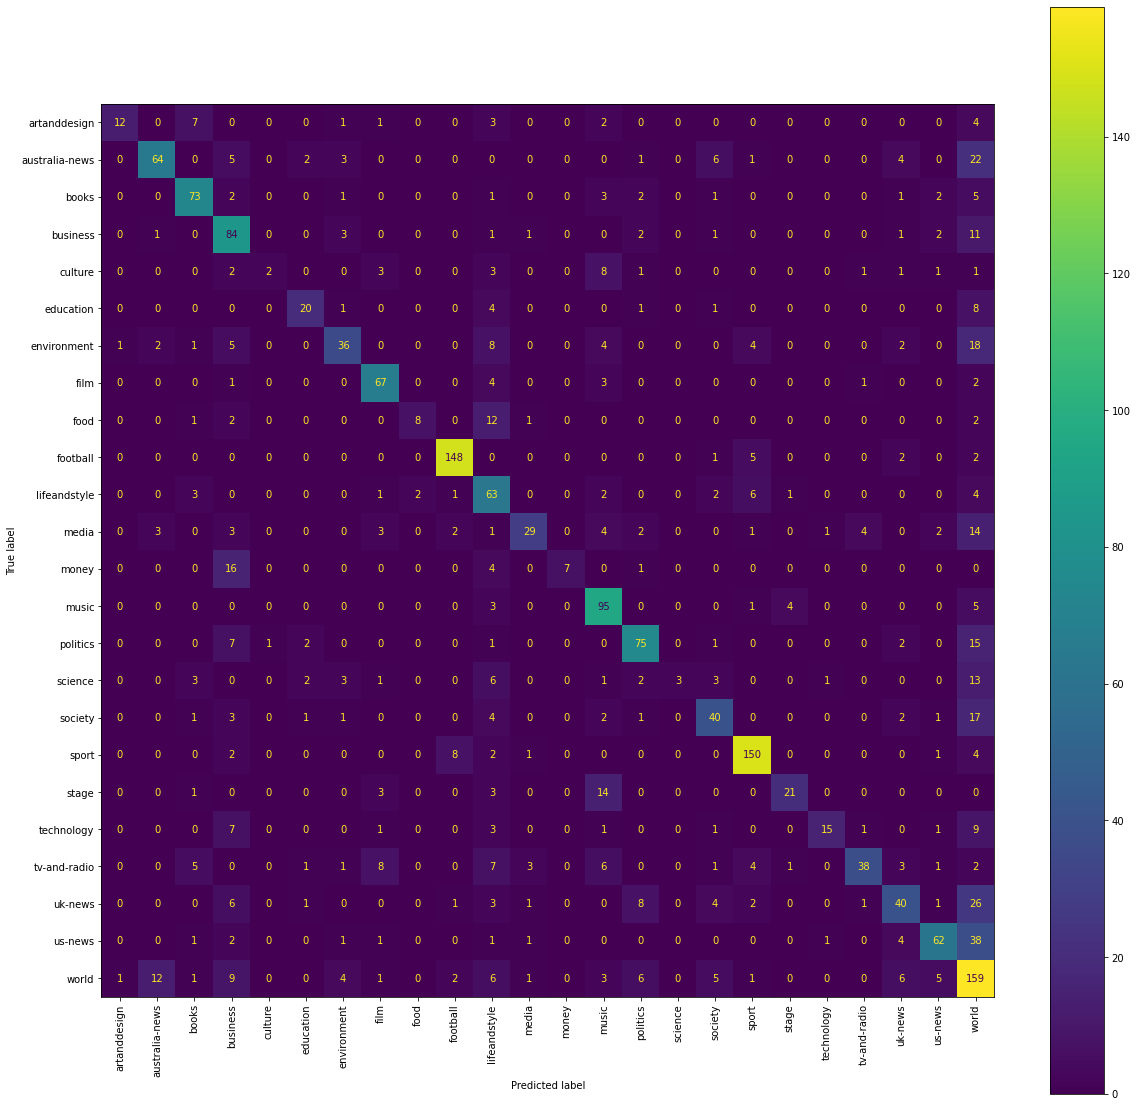

In [87]:
make_confusion_matrix(sent_model, X_test_vector_sentNo, y_test['sectionId'])

**It doesn't perform any worse, and given the small overhead, is worth keeping as the difference may become more pronounced with the full dataset.**

### vary max_features

**Another obvious parameter to tweak is the total number of words in the vocabulary. Here I try sizes between 200 and 5000 at 250 word intervals and plot the results.**

In [ ]:
train_feat_dic={}
for n in range(200, 5000, 250):
    print(n)
    tfidf_stem2 = TfidfVectorizer(
        max_features=n,
        stop_words=stemmed_stopwords,
        tokenizer=stem_and_tokenize)

    X_train_vector_stem2 = tfidf_stem2.fit_transform(X_train["bodyText"])
    X_train_vector_sentNo2 = sp.sparse.hstack((X_train_vector_stem2, extracted_col1))
    sentsize_cv2 = np.mean(cross_val_score(baseline_model, X_train_vector_sentNo2, y_train['sectionId']))
    train_feat_dic[n] = sentsize_cv2



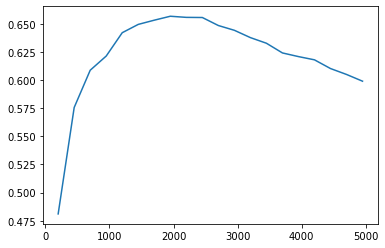

In [63]:
names = list(train_feat_dic.keys())
values1 = list(train_feat_dic.values())

plt.plot(names, values1)
plt.show()

**200 seems to perform best**

#### Model max_features

In [78]:
tfidf_stem_final = TfidfVectorizer(
    max_features=2000,
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize)

X_train_vector_stem_final = tfidf_stem_final.fit_transform(X_train["bodyText"])
X_train_vector_sent_final = sp.sparse.hstack((X_train_vector_stem_final, extracted_col1))

sentsize_final = np.mean(cross_val_score(baseline_model, X_train_vector_sent_final, y_train['sectionId']))
sentsize_final

0.65625

In [79]:
X_test_vector_stem_final = tfidf_stem_final.transform(X_test["bodyText"])
X_test_vector_sent_final = sp.sparse.hstack((X_test_vector_stem_final, extracted_col_test))

<ipython-input-83-630b76b753b8>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(x_list, rotation=45);


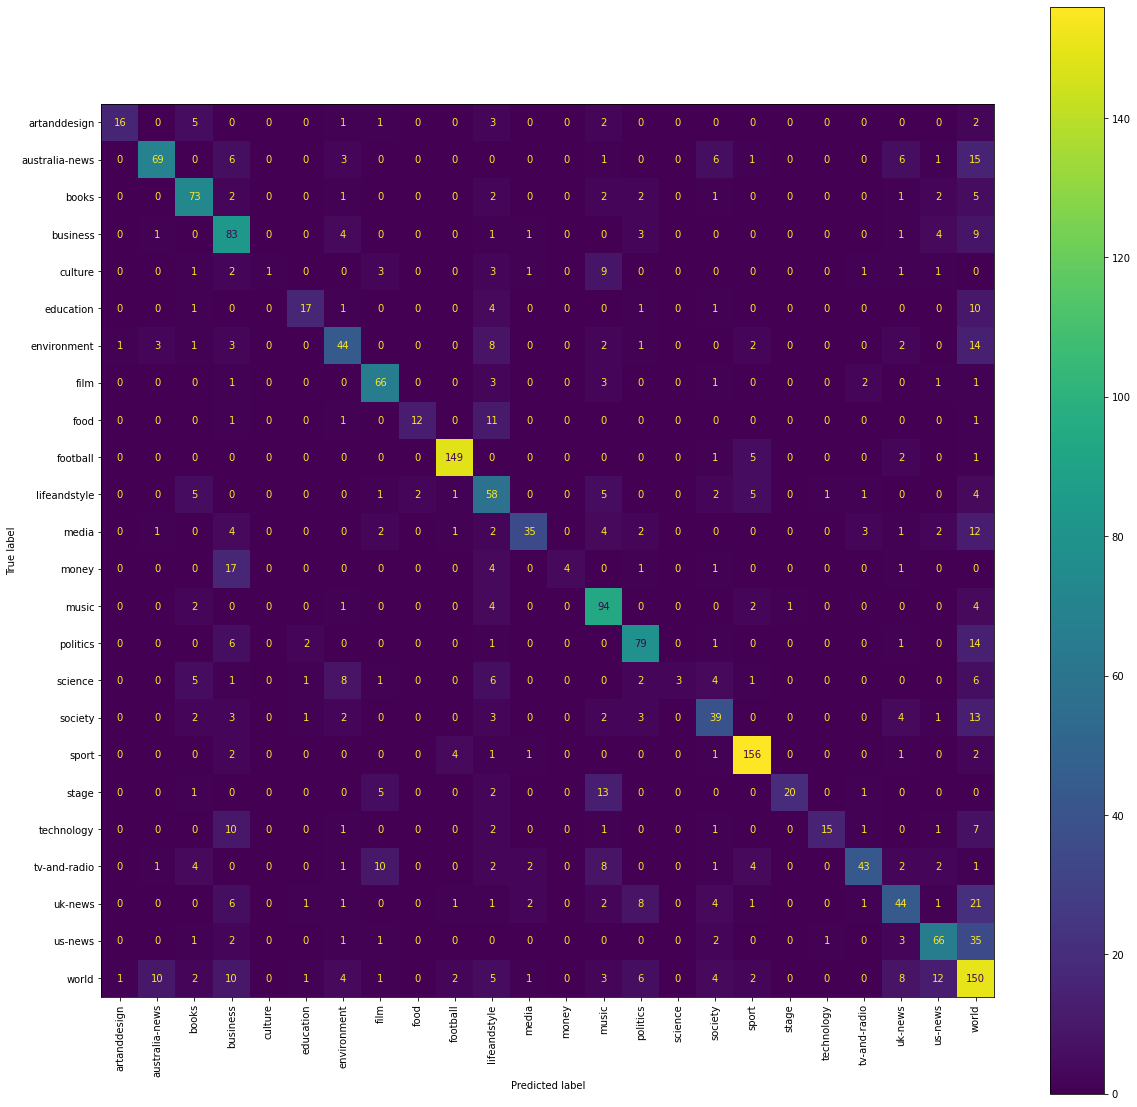

In [84]:
final_sent_model = MultinomialNB()
final_sent_model.fit(X_train_vector_sent_final, y_train['sectionId'])
make_confusion_matrix(final_sent_model, X_test_vector_sent_final, y_test['sectionId'])

In [85]:
print(make_class_report(final_sent_model, X_test_vector_sent_final, y_test['sectionId']))

                precision    recall  f1-score   support

  artanddesign      0.889     0.533     0.667        30
australia-news      0.812     0.639     0.715       108
         books      0.709     0.802     0.753        91
      business      0.522     0.776     0.624       107
       culture      1.000     0.043     0.083        23
     education      0.739     0.486     0.586        35
   environment      0.595     0.543     0.568        81
          film      0.725     0.846     0.781        78
          food      0.857     0.462     0.600        26
      football      0.943     0.943     0.943       158
  lifeandstyle      0.460     0.682     0.550        85
         media      0.814     0.507     0.625        69
         money      1.000     0.143     0.250        28
         music      0.623     0.870     0.726       108
      politics      0.731     0.760     0.745       104
       science      1.000     0.079     0.146        38
       society      0.557     0.534     0.545  

**Again, no massive difference, but we know it's the best value so should keep. Again, it may become more pronounced with a bigger dataset.**

### Try find special words to separate often confused columns

**Here I manually try to find words that appear in oft-confused columns but not in the other. The OHE them and add to vector to see if it helps.**

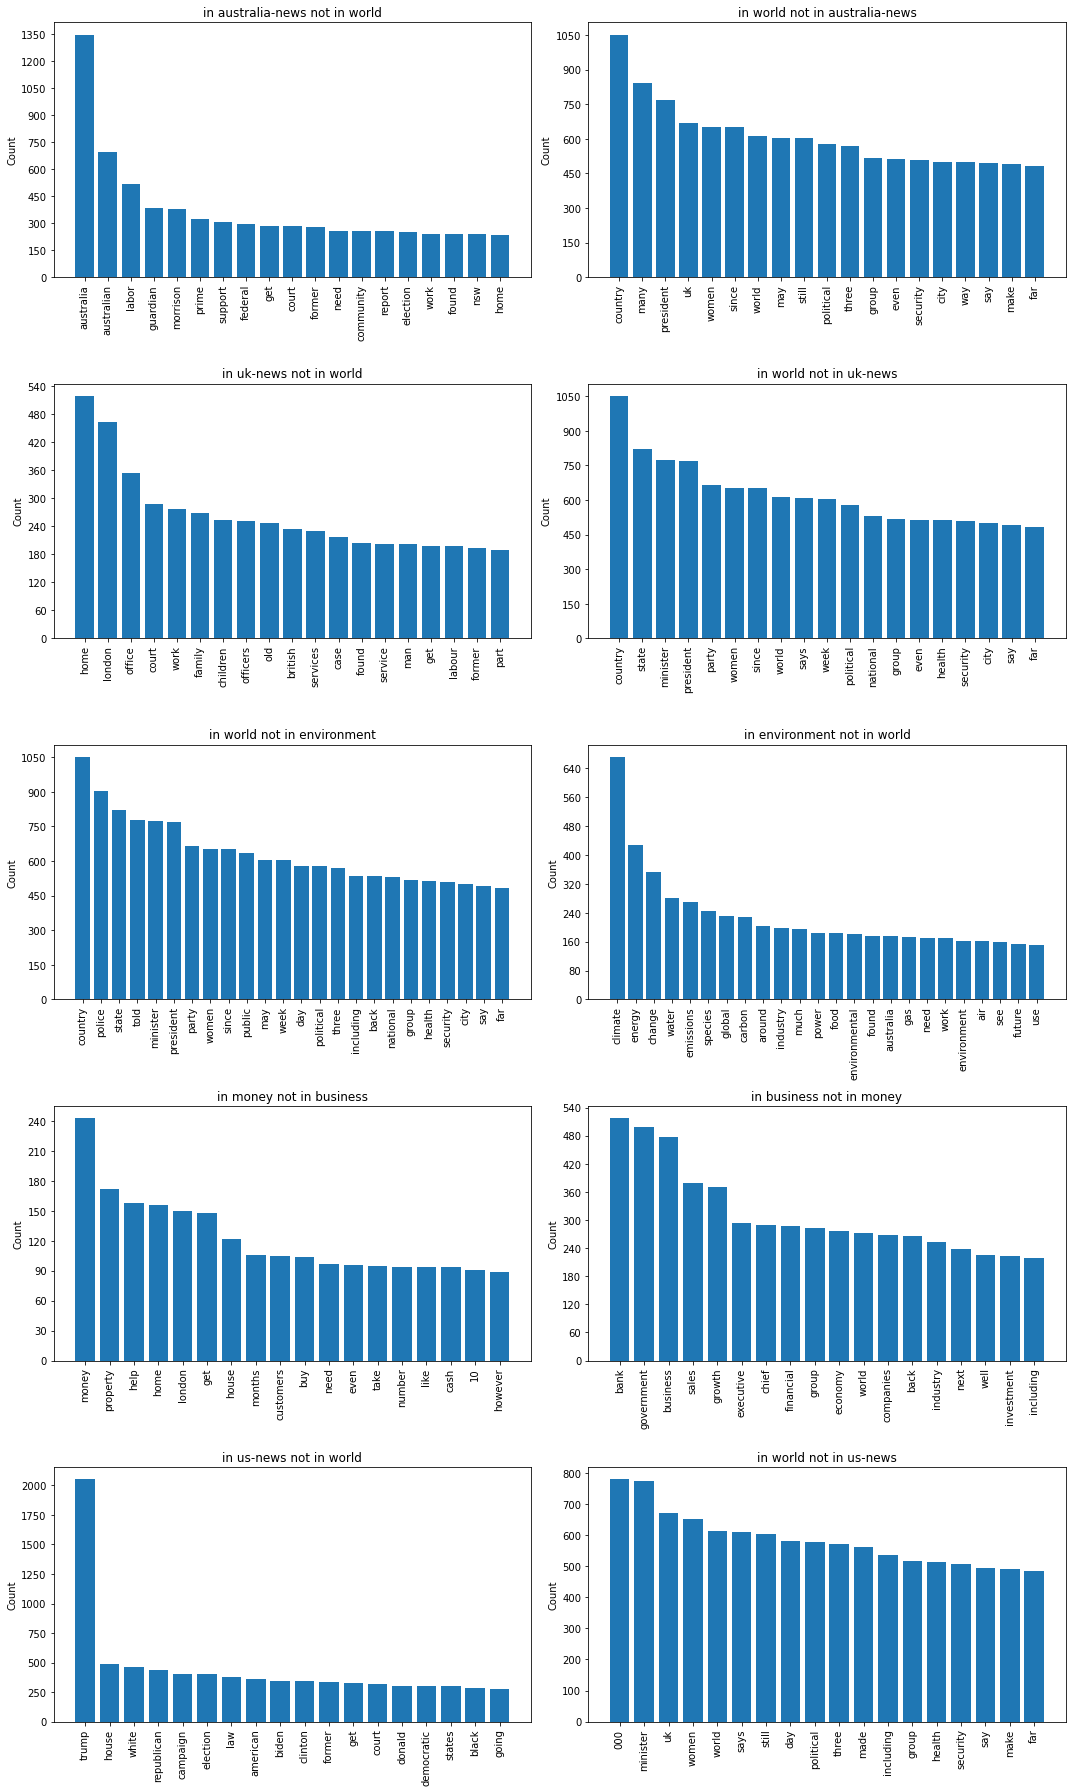

Text(0.5, 0.98, 'Word Frequencies for All Tokens')

In [90]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,25))
cat_list=[('australia-news', 'world'), ('uk-news', 'world'), ('world', 'environment'), ('money', 'business'), ('us-news', 'world')]
master_count=0
for i, c in enumerate(cat_list):
    row = master_count
    all_words_0 = X_train_nostop[X_train_nostop["label"] == c[0]]['text_tokenized'].explode()
    all_words_1 = X_train_nostop[X_train_nostop["label"] == c[1]]['text_tokenized'].explode()
    
    freq_dist_0 = FreqDist(all_words_0)
    freq_dist_1 = FreqDist(all_words_1)
    
    top_50_0= list(zip(*freq_dist_0.most_common(50)))
    top_50_1= list(zip(*freq_dist_1.most_common(50)))
    

    tokens_0 = top_50_0[0]
    tokens_1 = top_50_1[0]
    
    zero_not_one = [x for x in freq_dist_0.most_common(50) if x[0] not in tokens_1]
    one_not_zero = [y for y in freq_dist_1.most_common(50) if y[0] not in tokens_0]
    
    counts_0_1 = [a[1] for a in zero_not_one]
    counts_1_0 = [b[1] for b in one_not_zero]
    
    
    tokens_0_1 = [c[0] for c in zero_not_one]
    tokens_1_0 = [d[0] for d in one_not_zero]
    
    counter=0
    for combo in ([tokens_0_1, counts_0_1], [tokens_1_0, counts_1_0]):
        if counter ==0:
            ccount = 1
        else:
            ccount = 0
        col = counter
        ax = axes[row][col]
        ax.bar(combo[0], combo[1])
        ax.set_title(f"in {c[counter]} not in {c[ccount]}")
        ax.set_ylabel("Count")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis="x", rotation=90)
        counter+=1
    master_count+=1
plt.tight_layout()
plt.show()
fig.suptitle("Word Frequencies for All Tokens", fontsize=24)

In [91]:
def count_word(x, special_word):
    list_words = [w for w in x if w == special_word]
    return len(list_words)

special_words =['australian', 'labor', 'london', 'court', 'money', 'mortgage', 'climate', 'emissions', 'american', 'democrats', 'minster', 'trump', 'biden', 'white']
special_words_df = pd.DataFrame(columns=special_words)
for special_word in special_words:
    special_words_df[special_word] = X_train['text_tokenized'].map((lambda x: count_word(x, special_word)))
special_words_df

,australian,labor,london,court,money,mortgage,climate,emissions,american,democrats,minster,trump,biden,white
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,5,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7996,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7997,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7998,0,0,3,0,0,0,0,0,0,0,0,0,0,4


In [92]:
X_train_special_words = special_words_df.join(pd.DataFrame(X_train_vector_sent_final.toarray()))
X_train_special_words 

,australian,labor,london,court,money,mortgage,climate,emissions,american,democrats,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.062500
1,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.103743,0.070259,0.000000,0.0,0.000000,0.0,0.0,0.0,0.037500
2,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.034945,0.000000,0.038444,0.0,0.000000,0.0,0.0,0.0,0.043750
3,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.168750
4,0,0,1,0,1,0,1,0,0,0,...,0.000000,0.079130,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.090625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0,0,0,0,0,0,0,0,0,0,...,0.026228,0.000000,0.000000,0.019457,0.0,0.029941,0.0,0.0,0.0,0.312500
7996,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.065066,0.0,0.0,0.0,0.087500
7997,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.034774,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.084375
7998,0,0,3,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.050336,0.0,0.000000,0.0,0.0,0.0,0.087500


#### Make model with special words

In [93]:
special_cv = cross_val_score(baseline_model, X_train_special_words, y_train['sectionId'])
special_cv

array([0.6375  , 0.591875, 0.60125 , 0.60375 , 0.595625])

In [94]:
# maybe warped by size v tfid. standardize
# try differnt weights
for we in [0.2, 0.5, 1, 2, 3, 4, 5]:
    for special_word in special_words:
        max_spec = X_train_special_words.nlargest(1,special_word)[special_word].values[0]
        X_train_special_words[special_word] = X_train_special_words[special_word].apply(lambda x: we*(x/max_spec))
    special_cv1 = cross_val_score(baseline_model, X_train_special_words, y_train['sectionId'])
    print(np.mean(special_cv1))
    
    

0.65625
0.657875
0.66
0.6625000000000001
0.660625
0.6577500000000001
0.654625


In [95]:
X_train_special_words[special_word] = X_train_special_words[special_word].apply(lambda x: 2*(x/max_spec))

In [96]:
special_cv1 = cross_val_score(baseline_model, X_train_special_words, y_train['sectionId'])
special_cv1

array([0.669375, 0.66625 , 0.65375 , 0.6375  , 0.648125])

#### test

In [97]:

special_words_df = pd.DataFrame(columns=special_words)

for special_word in special_words:
    special_words_df[special_word] = X_test['text_tokenized'].map((lambda x: count_word(x, special_word)))
    
special_words_df

,australian,labor,london,court,money,mortgage,climate,emissions,american,democrats,minster,trump,biden,white
0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,5,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,4
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1997,0,0,0,0,1,0,0,0,8,0,0,1,1,0
1998,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [98]:
X_test_special_words = special_words_df.join(pd.DataFrame(X_test_vector_sent_final.toarray()))
                                                                                
for special_word in special_words:
    max_spec = X_test_special_words.nlargest(1,special_word)[special_word].values[0]
    X_test_special_words[special_word] = X_test_special_words[special_word].apply(lambda x:2*(x/max_spec))

In [99]:
sent_model = MultinomialNB()
sent_model.fit(X_train_special_words, y_train['sectionId'])
sent_model.score(X_train_special_words, y_train['sectionId'])

0.7165

In [100]:
sent_model.score(X_test_special_words, y_test['sectionId'])

0.666

In [101]:
print(make_class_report(sent_model, X_test_special_words, y_test['sectionId']))

                precision    recall  f1-score   support

  artanddesign      0.889     0.533     0.667        30
australia-news      0.786     0.611     0.688       108
         books      0.689     0.780     0.732        91
      business      0.529     0.766     0.626       107
       culture      1.000     0.043     0.083        23
     education      0.750     0.514     0.610        35
   environment      0.615     0.593     0.604        81
          film      0.727     0.821     0.771        78
          food      0.846     0.423     0.564        26
      football      0.914     0.943     0.928       158
  lifeandstyle      0.457     0.694     0.551        85
         media      0.805     0.478     0.600        69
         money      0.833     0.179     0.294        28
         music      0.605     0.880     0.717       108
      politics      0.736     0.750     0.743       104
       science      1.000     0.105     0.190        38
       society      0.557     0.534     0.545  

<ipython-input-6-22f4a674cabe>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(x_list, rotation=45);


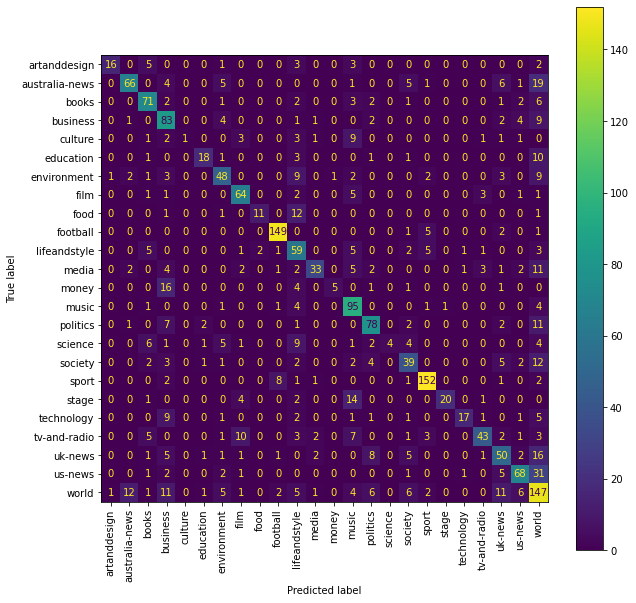

In [91]:
make_confusion_matrix(sent_model, X_test_special_words, y_test['sectionId'])

**There is definite improvement but more overfitting. With more time and computing power, I would look but more closely at developing this, but as it is, it is an expensive operation and doesn't really add enough value to be useful on the full dataset.**

### Bigrams

**Finally I used bigrams instead of individual words**

In [81]:
X_train_nostop['join_nostop'] = X_train_nostop['text_tokenized'].apply(lambda x: " ".join(x))
X_train_nostop

,bodyText,bodyTextlow,text_tokenized,label,join_nostop
0,"In the world of mainstream pop, Justin Timberl...","in the world of mainstream pop, justin timberl...","[world, mainstream, pop, justin, timberlake, c...",culture,world mainstream pop justin timberlake cuts cu...
1,Senior White House adviser Kellyanne Conway on...,senior white house adviser kellyanne conway on...,"[senior, white, house, adviser, kellyanne, con...",us-news,senior white house adviser kellyanne conway we...
2,Philip Hammond has been urged to scrap billion...,philip hammond has been urged to scrap billion...,"[philip, hammond, urged, scrap, billions, poun...",politics,philip hammond urged scrap billions pounds tax...
3,Javier Valdez wrote his own epitaph. After the...,javier valdez wrote his own epitaph. after the...,"[javier, valdez, wrote, epitaph, 23, march, mu...",world,javier valdez wrote epitaph 23 march murder mi...
4,With the health and social care system creakin...,with the health and social care system creakin...,"[health, social, care, system, creaking, alarm...",society,health social care system creaking alarmingly ...
...,...,...,...,...,...
7995,The extent of Rory McIlroy’s youth is often lo...,the extent of rory mcilroy’s youth is often lo...,"[extent, rory, mcilroy, youth, often, lost, an...",sport,extent rory mcilroy youth often lost analysis ...
7996,Greek Cypriots go to the polls on Sunday in a ...,greek cypriots go to the polls on sunday in a ...,"[greek, cypriots, go, polls, sunday, tight, pr...",world,greek cypriots go polls sunday tight president...
7997,After the most unsurprising of results Arsène ...,after the most unsurprising of results arsène ...,"[unsurprising, results, arsène, wenger, left, ...",football,unsurprising results arsène wenger left fully ...
7998,Pupils could complete their GCSEs and leave se...,pupils could complete their gcses and leave se...,"[pupils, could, complete, gcses, leave, second...",education,pupils could complete gcses leave secondary sc...


In [82]:
vectorizer = TfidfVectorizer(ngram_range =( 2 , 2 ), max_features=4000)

X2 = vectorizer.fit_transform(X_train_nostop['join_nostop'])


In [83]:
X_train_vector_bigram = sp.sparse.hstack((X2, extracted_col1))

In [84]:
bigram_cv = cross_val_score(baseline_model, X_train_vector_bigram, y_train['sectionId'])
bigram_cv

array([0.531875, 0.534375, 0.5425  , 0.521875, 0.51    ])

## Other models

**Having decided my final tf/idf and processing params, I used different model types to fit the vector and evaluated.**

In [102]:
lr_model=LogisticRegression()

In [103]:
rf_model=RandomForestClassifier(n_estimators=100, verbose=True)

In [104]:
svc_model=SVC()

In [105]:
xgb_model = XGBClassifier(max_depth=2)

In [106]:
rf_cv = cross_val_score(lr_model, X_train_special_words, y_train['sectionId'])

In [107]:
lr_cv = cross_val_score(rf_model, X_train_special_words, y_train['sectionId'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [108]:
svc_cv = cross_val_score(svc_model, X_train_special_words, y_train['sectionId'])

In [109]:
xgb_cv = cross_val_score(xgb_model, X_train_special_words, y_train['sectionId'])

C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:29:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:31:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:32:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:33:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

In [110]:
print(f'NB - {np.mean(special_cv1)}, SVC - {np.mean(svc_cv)}, XGB - {np.mean(xgb_cv)},  LR - {np.mean(lr_cv)}, RF - {np.mean(rf_cv)}')

NB - 0.655, SVC - 0.6955, XGB - 0.6863750000000001,  LR - 0.6463749999999999, RF - 0.7114999999999999


#### Tests

In [111]:
lr_model.fit(X_train_special_words, y_train['sectionId'])
lr_model.score(X_train_special_words, y_train['sectionId'])

C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.833375

In [112]:
lr_model.score(X_test_special_words, y_test['sectionId'])

0.7195

**Overfitting, so tweak reg params**

In [113]:
print(make_class_report(lr_model, X_test_special_words, y_test['sectionId']))

                precision    recall  f1-score   support

  artanddesign      0.850     0.567     0.680        30
australia-news      0.802     0.639     0.711       108
         books      0.773     0.824     0.798        91
      business      0.669     0.757     0.711       107
       culture      0.750     0.130     0.222        23
     education      0.676     0.714     0.694        35
   environment      0.639     0.568     0.601        81
          film      0.786     0.846     0.815        78
          food      0.762     0.615     0.681        26
      football      0.950     0.968     0.959       158
  lifeandstyle      0.508     0.706     0.591        85
         media      0.754     0.623     0.683        69
         money      0.938     0.536     0.682        28
         music      0.772     0.815     0.793       108
      politics      0.716     0.702     0.709       104
       science      1.000     0.289     0.449        38
       society      0.620     0.603     0.611  

<ipython-input-35-d78ae98f6f6e>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(x_list, rotation=45);


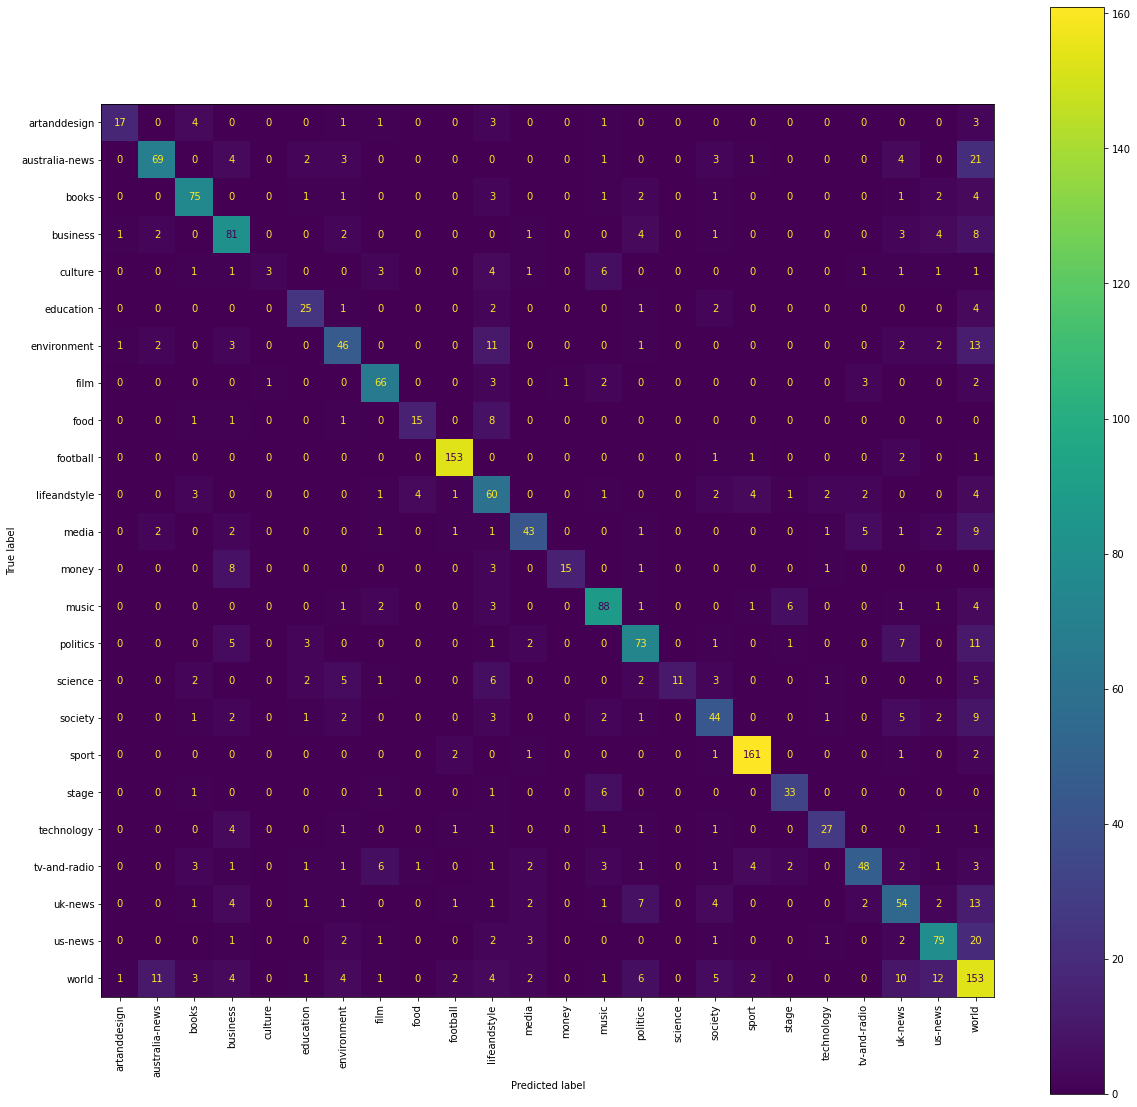

In [96]:
make_confusion_matrix(lr_model, X_test_special_words, y_test['sectionId'])

### tune lr

In [77]:
for cc in [1.5, 2, 3, 4, 5]:
    lr_model_c=LogisticRegression(C=cc)
    lr_model_c.fit(X_train_special_words, y_train['sectionId'])
    tr = lr_model_c.score(X_train_special_words, y_train['sectionId'])
    te = lr_model_c.score(X_test_special_words, y_test['sectionId'])
    print(f'{cc} = test {te}, train {tr}')

C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1.5 = test 0.719, train 0.849625


C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2 = test 0.7225, train 0.86025


C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


3 = test 0.725, train 0.874


C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


4 = test 0.725, train 0.87775
5 = test 0.724, train 0.887375


C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [79]:
X_test_special_words

,australian,labor,london,court,money,mortgage,climate,emissions,american,democrats,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
0,0.0,0.0,0.000000,0.0,0.615385,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.094275,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.054974
1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.024915,0.033746,0.054818,0.0,0.042177,0.0,0.0,0.000000,0.078534
2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.181818,0.0,...,0.0,0.022909,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.075916
3,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.181818,0.0,...,0.0,0.000000,0.000000,0.080079,0.0,0.000000,0.0,0.0,0.000000,0.120419
4,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.102094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.034260,0.000000,0.037690,0.0,0.000000,0.0,0.0,0.000000,0.081152
1996,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.013089
1997,0.0,0.0,0.000000,0.0,0.153846,0.0,0.0,0.0,1.454545,0.0,...,0.0,0.000000,0.000000,0.051445,0.0,0.000000,0.0,0.0,0.000000,0.130890
1998,0.0,0.0,0.142857,0.0,0.000000,0.0,0.0,0.0,0.181818,0.0,...,0.0,0.000000,0.041741,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.039267


<ipython-input-83-630b76b753b8>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(x_list, rotation=45);


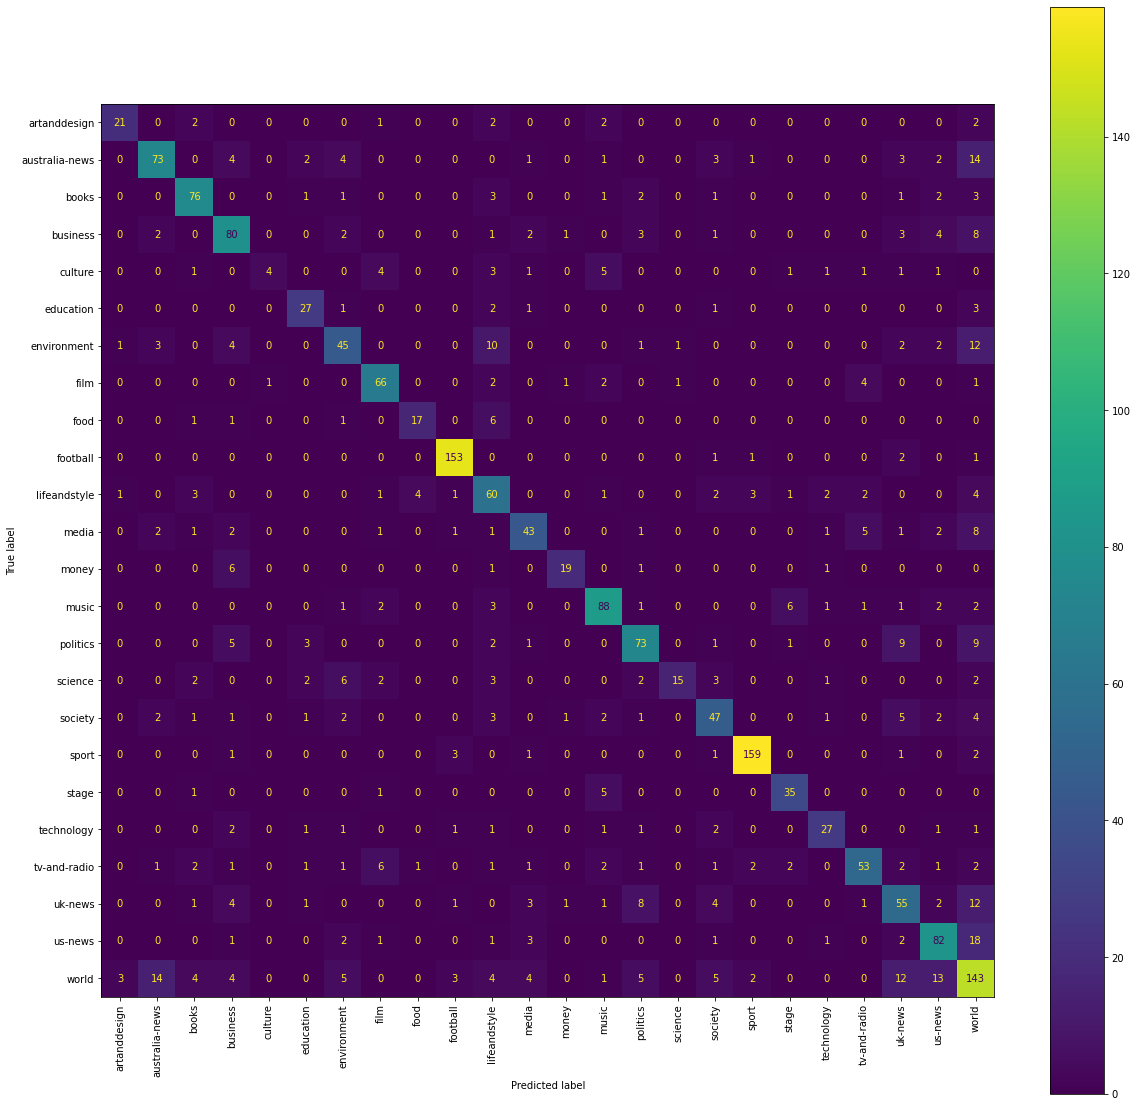

In [114]:
final_lr = LogisticRegression(C=3, solver='liblinear')
final_lr.fit(X_train_special_words, y_train['sectionId'])
make_confusion_matrix(final_lr, X_test_special_words, y_test['sectionId'])

In [115]:
print(make_class_report(final_lr, X_test_special_words, y_test['sectionId']))

                precision    recall  f1-score   support

  artanddesign      0.808     0.700     0.750        30
australia-news      0.753     0.676     0.712       108
         books      0.800     0.835     0.817        91
      business      0.690     0.748     0.717       107
       culture      0.800     0.174     0.286        23
     education      0.692     0.771     0.730        35
   environment      0.625     0.556     0.588        81
          film      0.776     0.846     0.810        78
          food      0.773     0.654     0.708        26
      football      0.939     0.968     0.953       158
  lifeandstyle      0.550     0.706     0.619        85
         media      0.705     0.623     0.662        69
         money      0.826     0.679     0.745        28
         music      0.786     0.815     0.800       108
      politics      0.730     0.702     0.716       104
       science      0.882     0.395     0.545        38
       society      0.635     0.644     0.639  

### rf

In [116]:
rf_model.fit(X_train_special_words, y_train['sectionId'])
rf_model.score(X_train_special_words, y_train['sectionId'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


1.0

In [117]:
rf_model.score(X_test_special_words, y_test['sectionId'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


0.6445

In [118]:
print(make_class_report(rf_model, X_test_special_words, y_test['sectionId']))

                precision    recall  f1-score   support

  artanddesign      0.739     0.567     0.642        30
australia-news      0.682     0.815     0.743       108
         books      0.733     0.846     0.786        91
      business      0.570     0.682     0.621       107
       culture      1.000     0.087     0.160        23
     education      0.704     0.543     0.613        35
   environment      0.704     0.469     0.563        81
          film      0.686     0.897     0.778        78
          food      0.667     0.308     0.421        26
      football      0.892     0.937     0.914       158
  lifeandstyle      0.519     0.659     0.580        85
         media      0.792     0.275     0.409        69
         money      1.000     0.214     0.353        28
         music      0.643     0.852     0.733       108
      politics      0.649     0.692     0.670       104
       science      1.000     0.079     0.146        38
       society      0.651     0.384     0.483  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
<ipython-input-35-d78ae98f6f6e>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(x_list, rotation=45);


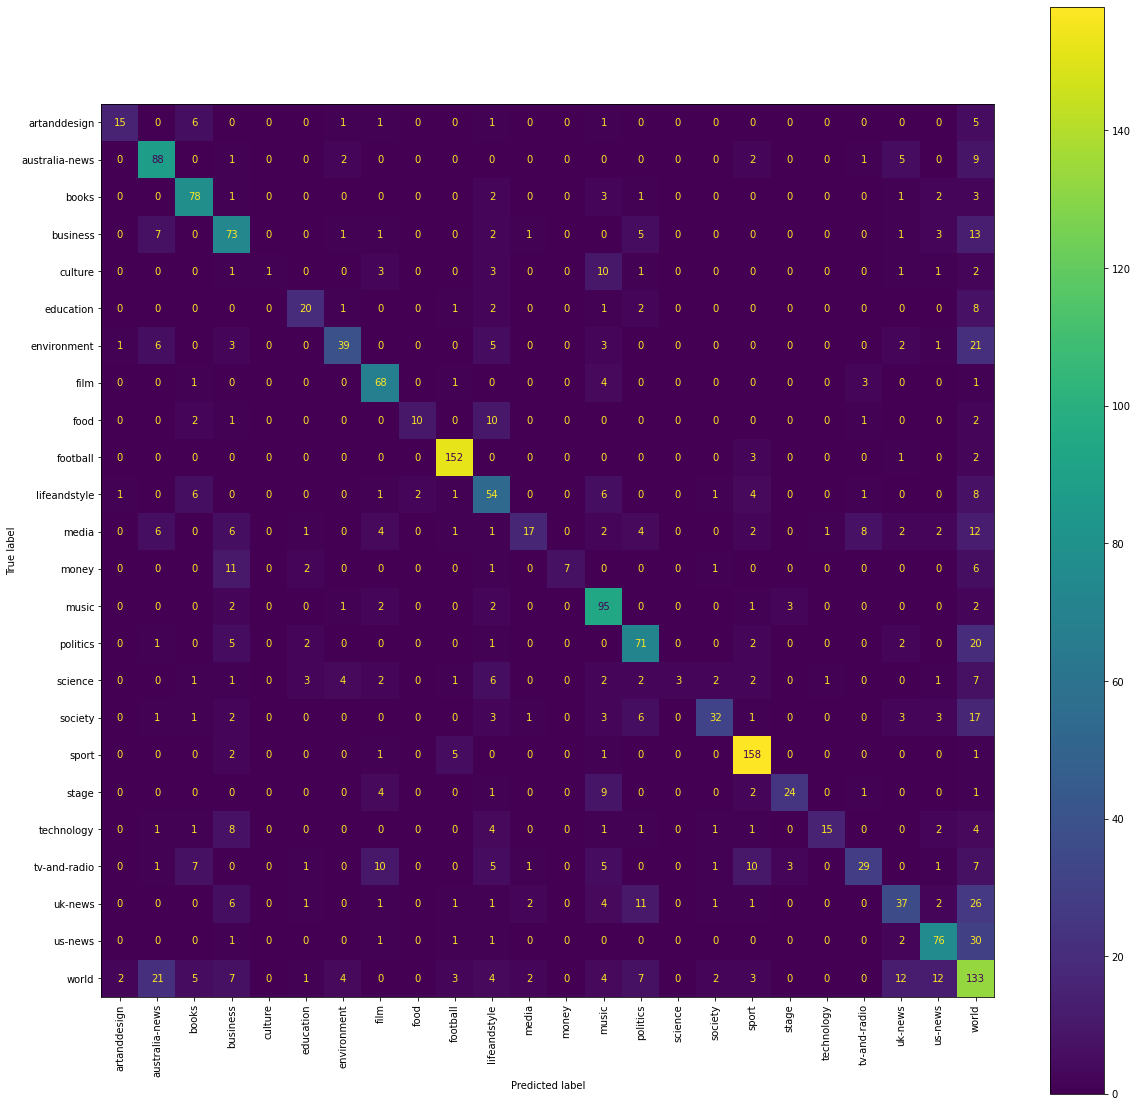

In [101]:
make_confusion_matrix(rf_model, X_test_special_words, y_test['sectionId'])

### svc

In [119]:
svc_model.fit(X_train_special_words, y_train['sectionId'])
svc_model.score(X_train_special_words, y_train['sectionId'])

0.926

In [120]:
svc_model.score(X_test_special_words, y_test['sectionId'])

0.7115

In [121]:
print(make_class_report(svc_model, X_test_special_words, y_test['sectionId']))

                precision    recall  f1-score   support

  artanddesign      0.741     0.667     0.702        30
australia-news      0.753     0.676     0.712       108
         books      0.809     0.835     0.822        91
      business      0.595     0.729     0.655       107
       culture      0.500     0.174     0.258        23
     education      0.619     0.743     0.675        35
   environment      0.637     0.630     0.634        81
          film      0.771     0.821     0.795        78
          food      0.800     0.615     0.696        26
      football      0.944     0.956     0.950       158
  lifeandstyle      0.512     0.753     0.610        85
         media      0.774     0.594     0.672        69
         money      0.714     0.357     0.476        28
         music      0.830     0.815     0.822       108
      politics      0.747     0.654     0.697       104
       science      0.909     0.263     0.408        38
       society      0.662     0.589     0.623  

<ipython-input-35-d78ae98f6f6e>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(x_list, rotation=45);


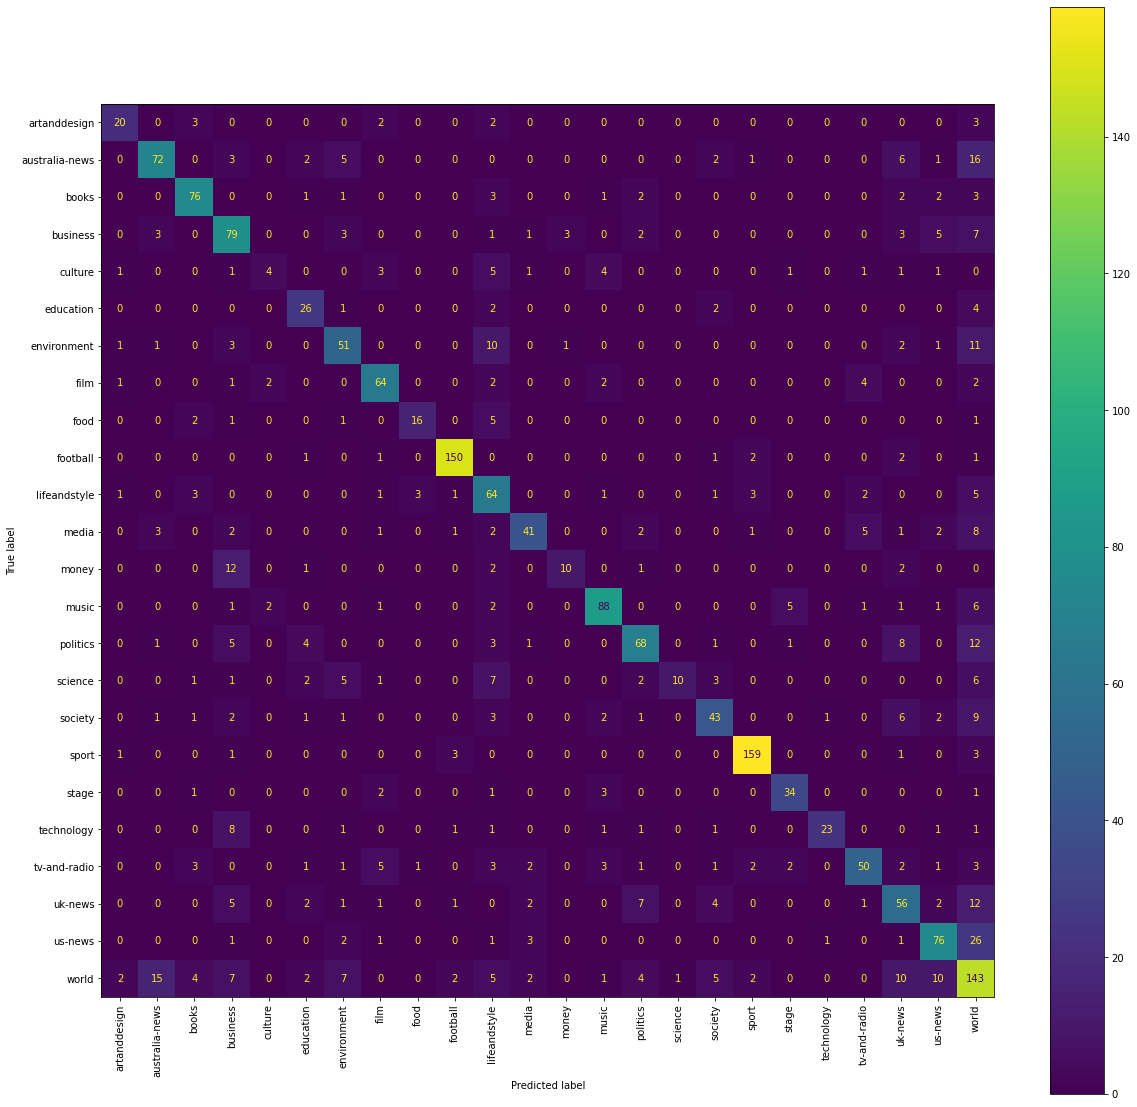

In [104]:
make_confusion_matrix(svc_model, X_test_special_words, y_test['sectionId'])

### xgb

In [122]:
xgb_model.fit(X_train_special_words, y_train['sectionId'])
xgb_model.score(X_train_special_words, y_train['sectionId'])

C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:50:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.95

In [123]:
xgb_model.score(X_test_special_words, y_test['sectionId'])

0.6905

In [124]:
print(make_class_report(xgb_model, X_test_special_words, y_test['sectionId']))

                precision    recall  f1-score   support

  artanddesign      0.654     0.567     0.607        30
australia-news      0.726     0.787     0.756       108
         books      0.752     0.868     0.806        91
      business      0.632     0.673     0.652       107
       culture      0.429     0.130     0.200        23
     education      0.591     0.743     0.658        35
   environment      0.667     0.543     0.599        81
          film      0.700     0.808     0.750        78
          food      0.688     0.423     0.524        26
      football      0.912     0.924     0.918       158
  lifeandstyle      0.505     0.588     0.543        85
         media      0.629     0.565     0.595        69
         money      0.765     0.464     0.578        28
         music      0.786     0.815     0.800       108
      politics      0.722     0.673     0.697       104
       science      0.688     0.289     0.407        38
       society      0.662     0.589     0.623  

<ipython-input-35-d78ae98f6f6e>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(x_list, rotation=45);


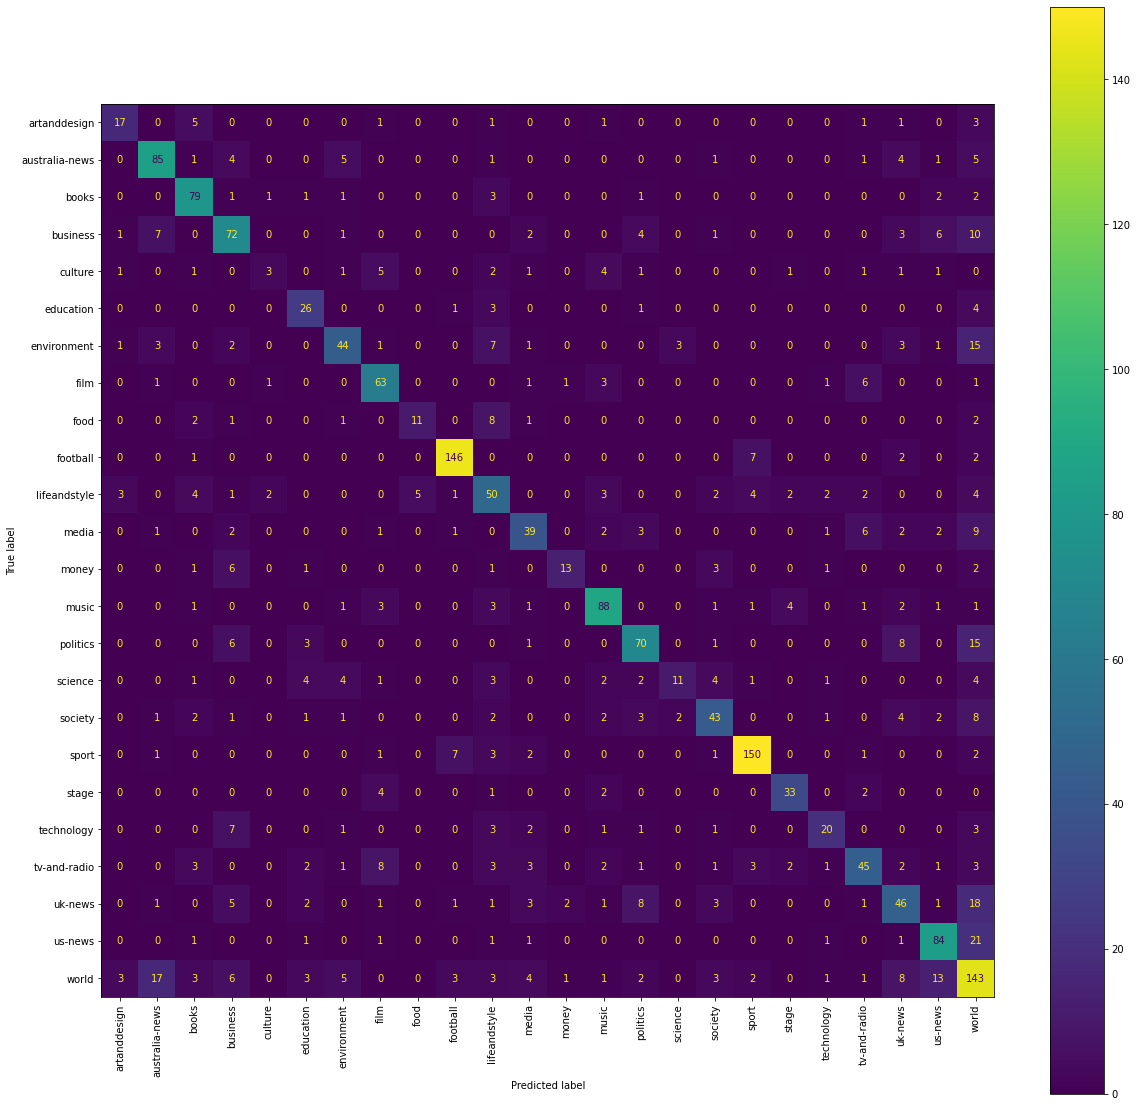

In [107]:
make_confusion_matrix(xgb_model, X_test_special_words, y_test['sectionId'])

**Overall we see LR-72%, rf 65%, svc 71%, xgb 69%. All show a lot of overfitting, tweaking params in LogReg made little difference. Rather than waste time trying to tune all the models, we hope that much of the problem will go away with a larger dataset. LOgistic Regression looks a good option as is most accurate and also least memory hungry.**

# Word embeddings

**Finally we try a different vectorization method, using the pretrained Word2Vec glove import. We pare it down to the vocab of the dataset and then fit various different models  on it an evaluate. I need to use the actual word rather than stemmed word**

In [127]:
data = X_train_nostop['text_tokenized'].values
total_vocabulary = set(word for headline in data for word in headline)

In [128]:
glove = {}
with open('data/glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [129]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [130]:
rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression())])

xgb = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Grad Boost', XGBClassifier())])

In [131]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Logistic Regression', lr),
          ('Grad Boost', xgb)]

In [132]:
scores = [(name, cross_val_score(model, data, y_train['sectionId'], cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative so

[14:07:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:07:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [133]:
scores

[('Random Forest', 0.623),
 ('Support Vector Machine', 0.633375),
 ('Logistic Regression', 0.6601250000000001),
 ('Grad Boost', 0.64025)]

**Again, time and memory constraints mean little room for tuning, but we see similar, if not slightly worse performance than the tf/idf method.**